# Projet 7 : Implémentez un modèle de scoring

## Préparation de données et feature engineering : 

In [1]:
import os
os.environ["SETUPTOOLS_USE_DISTUTILS"] = "stdlib"

# Import setuptools
from setuptools import setup

In [2]:
import numpy as np
import pandas as pd
import gc
import time
import warnings

from contextlib import contextmanager
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, RFECV
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
#import shap
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Enable inline plotting
%matplotlib inline

Nous allons utiliser le kernel suivant disponible sur kaggle pour la partie feature engineering : https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

Quelques notes expliquant le feature engineering de ce kernel :

Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
Little feature selection is done and overfitting might be a problem since many features are related.
The following key ideas were used:
- Divide or subtract important features to get rates (like annuity and income)
- In Bureau Data: create specific features for Active credits and Closed credits
- In Previous Applications: create specific features for Approved and Refused applications
- Modularity: one function for each table (except bureau_balance and application_test)
- One-hot encoding for categorical features
All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).

Update 16/06/2018:
- Added Payment Rate feature
- Removed index from features
- Use standard KFold CV (not stratified)

In [5]:
data_files = 'C:/Users/guirletj/Desktop/Test_envir/Projet 7/input/'

In [19]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, dtype='uint8')
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    
    df = pd.read_csv(f"{data_files}{'application_train.csv'}", nrows= num_rows)
    test_df = pd.read_csv(f"{data_files}{'application_test.csv'}", nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df, test_df], ignore_index=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(f"{data_files}{'bureau.csv'}", nrows = num_rows)
    bb = pd.read_csv(f"{data_files}{'bureau_balance.csv'}", nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(f"{data_files}{'previous_application.csv'}", nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(f"{data_files}{'POS_CASH_balance.csv'}", nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(f"{data_files}{'installments_payments.csv'}", nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(f"{data_files}{'credit_card_balance.csv'}", nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

In [20]:
#ne pas relancer à chaque fois car assez long
df_merged = main(False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 30s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 55s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 27s
Installments payments df shape: (339587, 26)
Process installments payments - done in 49s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 39s


Exportons le fichier pour ne pas le recharger à chaque fois :

In [27]:
df_merged.to_csv('df_merged.csv', index=False)

In [3]:
df_merged = pd.read_csv('df_merged.csv')

In [41]:
#pour voir toutes les colonnes et lignes
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [265]:
df_merged.sample(5)

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
216841      351256     0.0            1             0                1   
288892      434688     0.0            1             0                0   
301628      449440     1.0            1             0                0   
322834      210523     NaN            0             1                1   
204403      336975     0.0            0             1                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
216841             1          202500.0    260640.0      24034.5   
288892             0          270000.0    481495.5      32436.0   
301628             1          202500.0    728712.0      23638.5   
322834             0          276300.0    450000.0      23107.5   
204403             3          360000.0   1006920.0      37444.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
216841         225000.0                    0.007330      -11628   
288892         454500.0                    0.010276      -21346   
301628         522000.0                    0.031329      -16418   
322834         450000.0                    0.035792      -10083   
204403         900000.0                    0.016612      -14320   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
216841         -788.0            -2749.0            -2755          NaN   
288892        -1272.0            -5400.0            -4319          NaN   
301628        -3835.0            -7574.0            -4202          NaN   
322834        -1733.0            -4696.0            -2546          9.0   
204403         -514.0            -1500.0            -3486          5.0   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
216841           1               1                0                 1   
288892           1               1                0                 1   
301628           1               1                0                 1   
322834           1               1                0                 1   
204403           1               1                0                 1   

        FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
216841           0           0              3.0                     2   
288892           0           0              2.0                     2   
301628           0           0              3.0                     2   
322834           0           0              1.0                     2   
204403           1           0              5.0                     2   

        REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
216841                            2                       10   
288892                            2                        9   
301628                            2                       10   
322834                            2                       12   
204403                            2                       10   

        REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
216841                           0                           0   
288892                           0                           0   
301628                           0                           0   
322834                           0                           0   
204403                           0                           0   

        LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
216841                            0                       0   
288892                            0                       0   
301628                            0                       0   
322834                            0                       1   
204403                            0                       0   

        REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
216841                       1                        1      0.317205   
288892                       0                        0      0.863847   
301628                       0                        

Regardons la taille de notre jeu de données : 

In [4]:
df_merged.shape

(356251, 797)

Vérifions si nous avions bien uniquement des variables numériques suite au 1er prétraitement : 

In [5]:
df_merged.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356251 entries, 0 to 356250
Data columns (total 797 columns):
 #    Column                                                                 Dtype  
---   ------                                                                 -----  
 0    SK_ID_CURR                                                             int64  
 1    TARGET                                                                 float64
 2    CODE_GENDER                                                            int64  
 3    FLAG_OWN_CAR                                                           int64  
 4    FLAG_OWN_REALTY                                                        int64  
 5    CNT_CHILDREN                                                           int64  
 6    AMT_INCOME_TOTAL                                                       float64
 7    AMT_CREDIT                                                             float64
 8    AMT_ANNUITY                     

Créons une fonction pour réduire la mémoire de notre dataframe :

In [269]:
# source pour réduire memoire du fichier : https://www.kaggle.com/code/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [270]:
df_merged = reduce_mem_usage(df_merged)

Memory usage of dataframe is 2166.23 MB
Memory usage after optimization is: 610.19 MB
Decreased by 71.8%


Nous avons donc gagné 1 GB de mémoire.

Aperçu des nouveaux types de données : 

In [257]:
df_merged.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356251 entries, 0 to 356250
Data columns (total 797 columns):
 #    Column                                                                 Dtype  
---   ------                                                                 -----  
 0    SK_ID_CURR                                                             int32  
 1    TARGET                                                                 float16
 2    CODE_GENDER                                                            int8   
 3    FLAG_OWN_CAR                                                           int8   
 4    FLAG_OWN_REALTY                                                        int8   
 5    CNT_CHILDREN                                                           int8   
 6    AMT_INCOME_TOTAL                                                       float32
 7    AMT_CREDIT                                                             float32
 8    AMT_ANNUITY                     

In [271]:
# Suppression des valeurs infinies dans df
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)

Nous constatons qu'il y a plusieurs valeurs infinies dans nos variables, nous allons donc les remplacer par nan pour ne pas que cela pose problème par la suite :

### Analyses univariées

#### Focus sur la target :

Regardons la répartition des targets dans le jeu de données :

In [50]:
df_merged['TARGET'].value_counts()

TARGET
0.0    282682
1.0     24825
Name: count, dtype: int64

La variable "Target" est la variable à prédire. Nous constatons que les résultats sont très asymétriques : 1 = risque du défaut et 0 = pas de risque de défaut.

Regardons visuellement ce que ça donne avec les données d'entrainement uniquement étant donné qu'il n'y a pas de target pour les données test.

In [51]:
df_merged_train = df_merged[df_merged['TARGET'].notnull()]

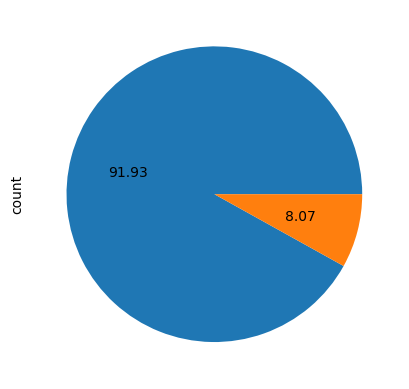

In [52]:
def autopct(pct): # only show the label when it's > 10%
    return ('%.2f' % pct) if pct > 5 else ''
# Diagramme en secteurs
ax = df_merged_train['TARGET'].value_counts().plot(kind='pie', autopct=autopct, labels=None)
plt.show() # Affiche le graphique

Regardons la distribution de certaines variables de notre jeu de données :

In [53]:
selection_variables = ['CODE_GENDER','CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY','DAYS_BIRTH']

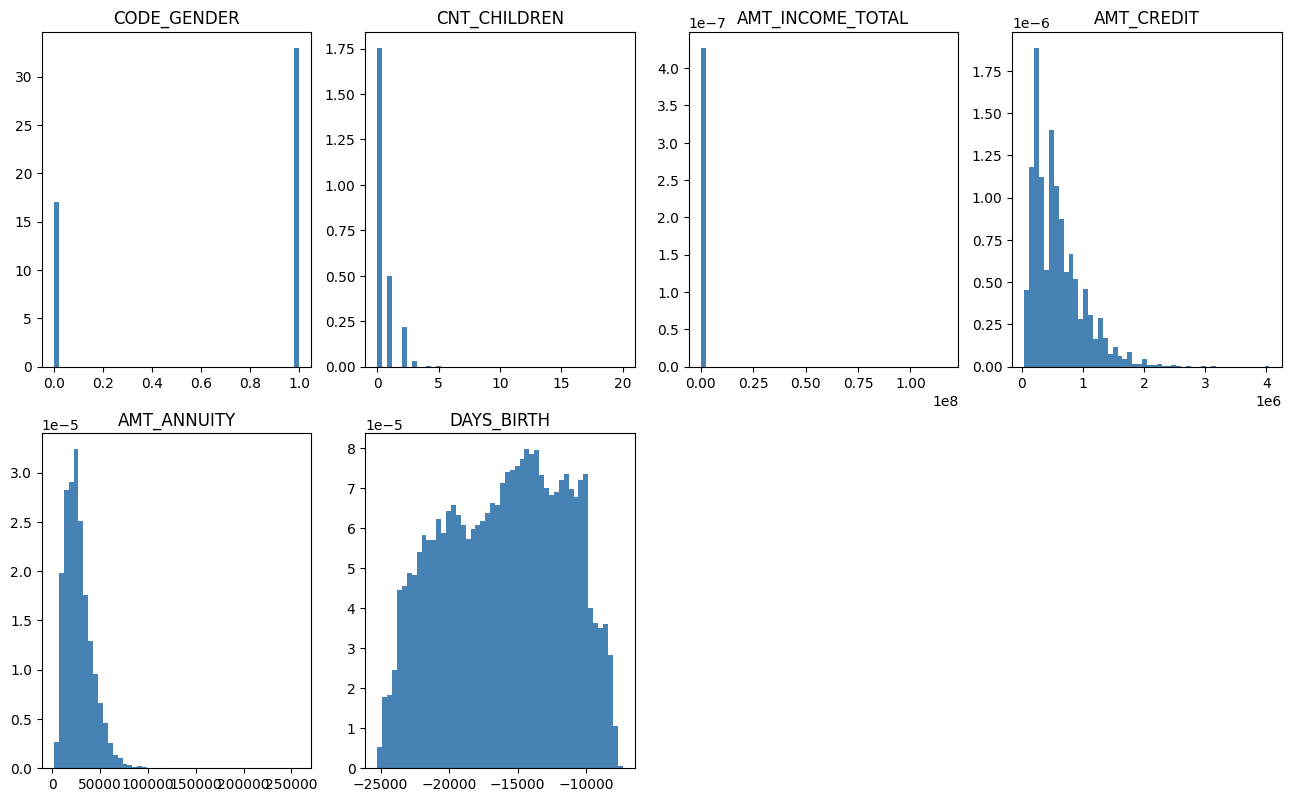

In [54]:
# visualisation des variables
fig = plt.figure(figsize=(16, 20))
for indice_col in range(df_merged[selection_variables].shape[1]):
    ax = fig.add_subplot(4, 4, (indice_col+1))
    nom_col = df_merged[selection_variables].iloc[:, indice_col].name
    h = ax.hist(df_merged[selection_variables].iloc[:, indice_col], bins=50, color='steelblue', 
                density=True, edgecolor='none')
    ax.set_title(nom_col, fontsize=12)

Nous constatons que la plupart de ces variables sont asymétriques.

### Analyses bivariées

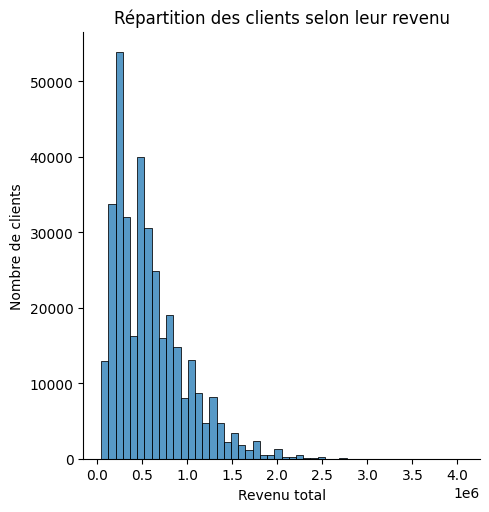

In [57]:
df_merged = df_merged.astype({'AMT_CREDIT': 'float64'})  # On change le type pour que la variable soit lue par seaborn
ax = sns.displot(x="AMT_CREDIT", data=df_merged, bins=50) #hue='TARGET'
plt.title('Répartition des clients selon leur revenu')
plt.xlabel('Revenu total')
plt.ylabel('Nombre de clients')
plt.rcParams["figure.figsize"] = (10, 5)

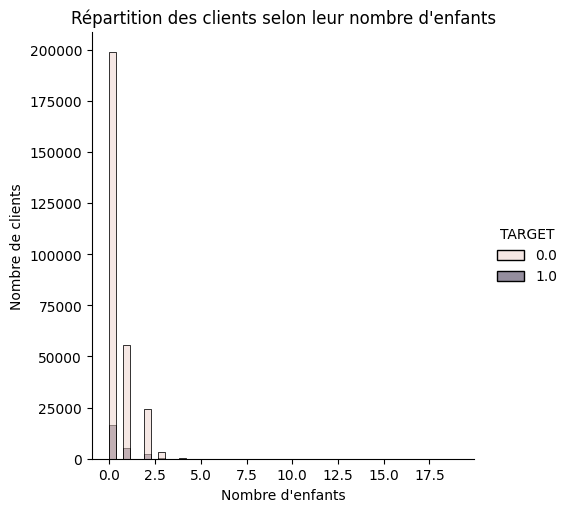

In [155]:
ax = sns.displot(x="CNT_CHILDREN", data=df_merged, hue='TARGET', bins=50)
plt.title("Répartition des clients selon leur nombre d'enfants")
plt.xlabel("Nombre d'enfants")
plt.ylabel('Nombre de clients')
plt.rcParams["figure.figsize"] = (10, 5)

La majorité des clients n'ont pas d'enfant. 

## Nettoyage des données 

### Séparation des jeux de données test et train

Etant donné qu'il s'agit de la variable à prédire, nous ne pouvons pas estimer les valeurs manquantes et supprimons donc les lignes n'ayant pas de valeurs --> nous enlevons donc le dataset test.

In [65]:
df_merged_train = df_merged[df_merged['TARGET'].notnull()]

In [66]:
df_merged_train.shape

(307507, 797)

In [67]:
df_merged_test = df_merged[df_merged['TARGET'].isnull()]

In [68]:
df_merged_test.shape

(48744, 797)

### Taux de remplissage par client

In [69]:
def taux_remplissage_par_client(dataframe):
    result = ((dataframe.shape[1]-dataframe.isnull().sum(axis=1))/dataframe.shape[1]).sort_values().reset_index()
    result.columns = ['Index','Taux de remplissage']
    return result

In [70]:
df_merged_taux_remplissage_par_client = taux_remplissage_par_client(df_merged_train)

In [71]:
df_merged_taux_remplissage_par_client.describe()

Index  Taux de remplissage
count  307507.000000        307507.000000
mean   153755.870793             0.740726
std     88770.888212             0.128906
min         0.000000             0.237139
25%     76878.500000             0.693852
50%    153756.000000             0.735257
75%    230633.500000             0.811794
max    307510.000000             1.000000

Nous constatons donc que 25% des clients ont moins de 69% de données renseignées.
Nous allons donc conserver uniquement les clients ayant plus de 69% de données complétées (la médiane étant à 74%).

In [72]:
liste_index_taux_sup_69 = df_merged_taux_remplissage_par_client.loc[df_merged_taux_remplissage_par_client['Taux de remplissage']>0.69]['Index'].tolist()

In [73]:
df_merged_1 = df_merged_train.loc[liste_index_taux_sup_69]

In [74]:
df_merged_1.shape[0]/df_merged_train.shape[0]

0.7789936489250652

Nous avons donc conservé 78% des clients.

 ### Taux de remplissage par variable

Regardons maintenant le taux de remplissage par variable :

In [75]:
def taux_remplissage_variable(dataframe):
    result = (1- (dataframe.isna().mean())).sort_values(ascending=False).reset_index()
    result.columns = ['Variables','Taux de remplissage']
    return result

In [76]:
df_merged_1_taux_remplissage_variable = taux_remplissage_variable(df_merged_1)

Regardons graphiquement ce que ça donne :

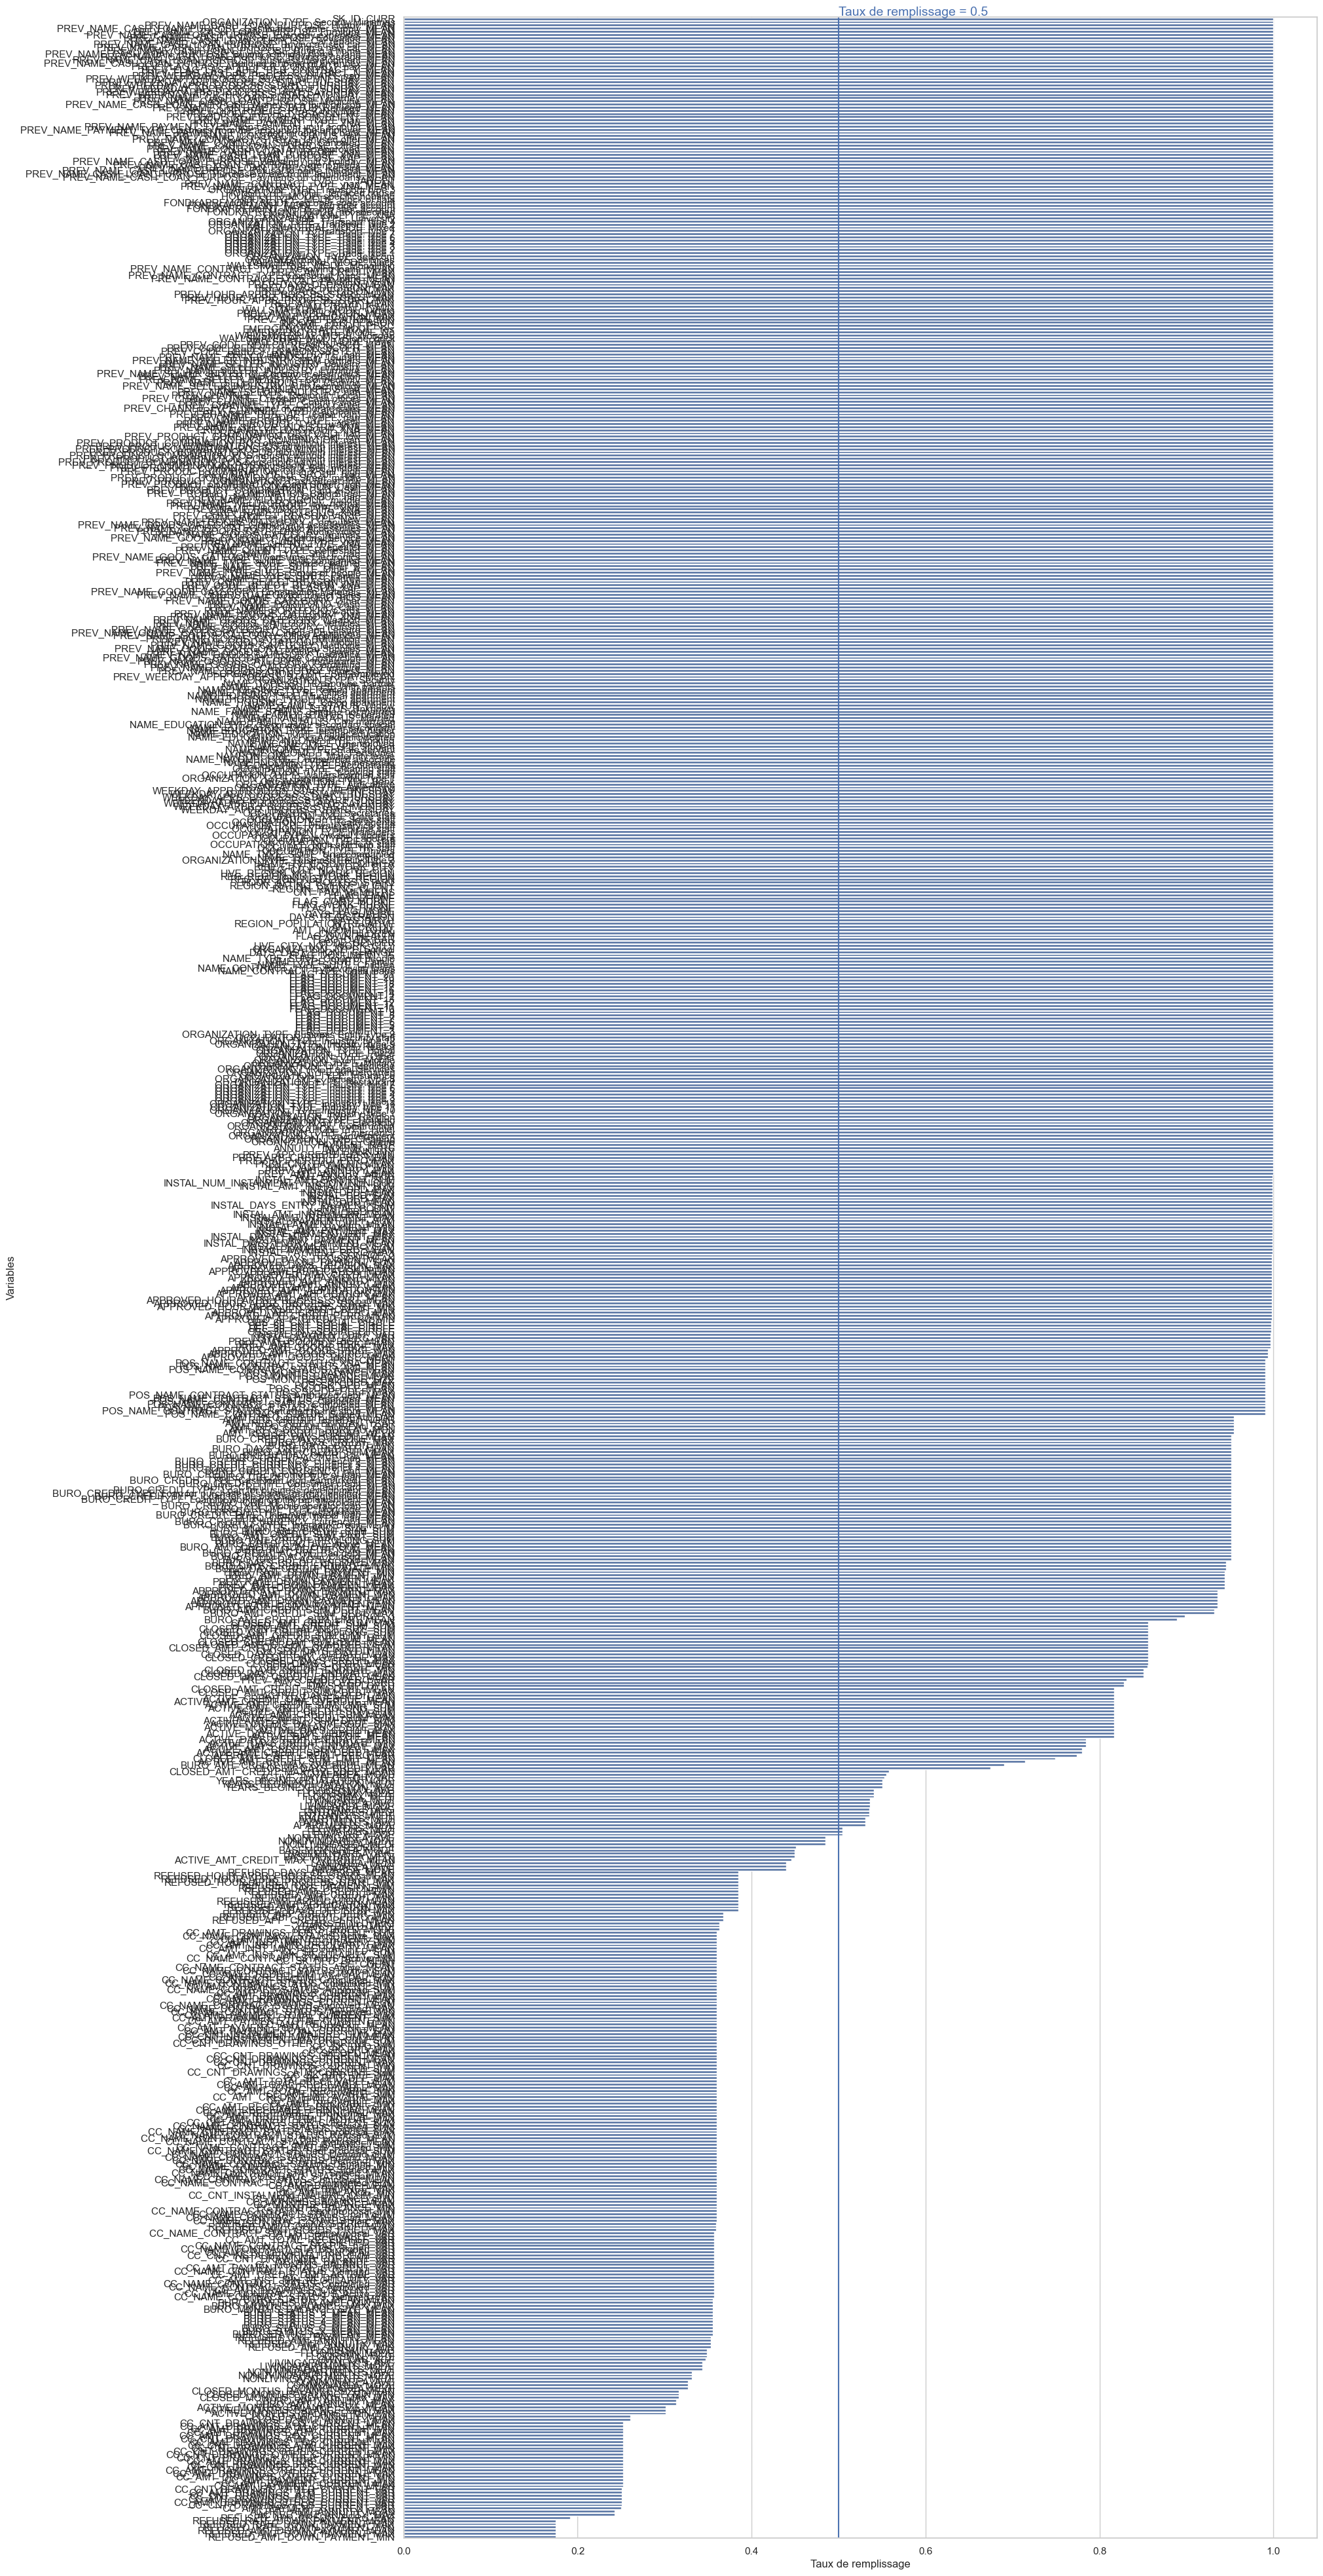

In [77]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18,50))
ax = sns.barplot(x="Taux de remplissage", y="Variables", data=df_merged_1_taux_remplissage_variable)
plt.axvline(x=0.5, ymin=0, ymax=len(df_merged_1_taux_remplissage_variable))
plt.text(0.50, -1, "Taux de remplissage = 0.5", fontsize= 14, color ='b')
plt.show()

Faisons la liste des variables ayant un taux de remplissage supérieur à 50%.

In [78]:
liste_index_taux_sup_50 = df_merged_1_taux_remplissage_variable.loc[df_merged_1_taux_remplissage_variable['Taux de remplissage']>0.5]['Variables'].tolist()

In [79]:
liste_index_taux_sup_50

['SK_ID_CURR',
 'ORGANIZATION_TYPE_Security Ministries',
 'PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Everyday expenses_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Car repairs_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a used car_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN',
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN',
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN',
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN',
 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN',
 'PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN',
 'PR

In [80]:
len(liste_index_taux_sup_50)/df_merged_1.shape[1]

0.7214554579673776

Nous allons supprimer les variables ayant un taux de remplissage inférieur à 50% ce qui correspond à 28% des variables.

In [81]:
df_merged_2 = df_merged_1.loc[:,liste_index_taux_sup_50]

In [82]:
df_merged_2.shape

(239546, 575)

In [84]:
df_merged_2.to_csv('df_merged_2.csv')

Pour entrainer notre modèle, nous allons bien utiliser uniquement les données d'entrainement étant donné qu'il n'y avait pas la variable "target" dans le jeu de test et que nous avons supprimer toutes les lignes sans valeur pour la target.

Nous avons encore 575 colonnes ce qui est beaucoup pour entrainer un modèle. Nous procéderons par une élimination des variables à faible variance dans un 1er temps puis par la méthode RFEC.

## Sélection des variables

### Suppression des variables à faible variance

Nous allons maintenant supprimer les variables numériques ayant une faible variance pour garder celles qui varient et pourraient avoir un levier décisionnel pour notre modèle.

In [85]:
# Identifions les variables catégorielles :
bool_cols = [col for col in df_merged_2 
             if np.isin(df_merged_2[col].dropna().unique(), [0, 1]).all()]

In [86]:
liste_variables = df_merged_2.columns.to_list()

In [260]:
# Isolons les variables numériques des variables catégorielles :
from collections import Counter
liste_variables_numeriques = list((Counter(liste_variables)-Counter(bool_cols)).elements())

In [88]:
def variance_threshold(df,th) :
    selector = VarianceThreshold(threshold=th)
    selector.fit(df)
    new_cols = selector.get_support()
    return  df.iloc[:,new_cols]

Standardisons les données pour calculer une variance homogène entre les différentes variables numériques à sélectionner :

In [89]:
scaler = RobustScaler()

In [90]:
df_merged_2_scaled = pd.DataFrame(scaler.fit_transform(df_merged_2[liste_variables_numeriques].values), columns=df_merged_2[liste_variables_numeriques].columns, index=df_merged_2[liste_variables_numeriques].index)

In [91]:
# enlevons l'identifiant client
df_merged_2_scaled.drop(columns=['SK_ID_CURR'], inplace=True)

In [92]:
thresholds = [x/100 for x in range (0,100,10)]

# optimisation du seuil de variance
for th in thresholds:
    nb_columns = variance_threshold(df_merged_2_scaled, th).shape[1]
    print("Threshold = ", th)
    print("Nombre de colonnes conservées = ", nb_columns)
    print("----")

Threshold =  0.0
Nombre de colonnes conservées =  386
----
Threshold =  0.1
Nombre de colonnes conservées =  260
----
Threshold =  0.2
Nombre de colonnes conservées =  259
----
Threshold =  0.3
Nombre de colonnes conservées =  249
----
Threshold =  0.4
Nombre de colonnes conservées =  232
----
Threshold =  0.5
Nombre de colonnes conservées =  220
----
Threshold =  0.6
Nombre de colonnes conservées =  201
----
Threshold =  0.7
Nombre de colonnes conservées =  182
----
Threshold =  0.8
Nombre de colonnes conservées =  167
----
Threshold =  0.9
Nombre de colonnes conservées =  151
----


In [93]:
feature_variance = pd.DataFrame()
feature_variance["feature"] = df_merged_2_scaled.columns

feature_variance["variance"] = df_merged_2_scaled.var(axis=0).to_list()
feature_variance.sort_values(by=["variance"], ascending=True, inplace=True)

In [94]:
feature_variance.loc[feature_variance['variance']<0.1].tail(20)

feature  variance
115  PREV_NAME_GOODS_CATEGORY_Clothing and Accessor...  0.011673
74             PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN  0.011887
103    PREV_PRODUCT_COMBINATION_Cash Street: high_MEAN  0.011889
80               PREV_CHANNEL_TYPE_Contact center_MEAN  0.012497
72         PREV_NAME_SELLER_INDUSTRY_Construction_MEAN  0.013054
88      PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN  0.014149
83              PREV_CHANNEL_TYPE_AP+ (Cash loan)_MEAN  0.015178
126          PREV_NAME_TYPE_SUITE_Spouse, partner_MEAN  0.020155
156            PREV_NAME_GOODS_CATEGORY_Furniture_MEAN  0.022522
321                      CLOSED_CNT_CREDIT_PROLONG_SUM  0.024169
70            PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN  0.024600
96   PREV_PRODUCT_COMBINATION_POS household without...  0.029888
109              PREV_NAME_YIELD_GROUP_low_action_MEAN  0.030853
117          PREV_NAME_GOODS_CATEGORY_Audio/Video_MEAN  0.032206
114            PREV_NAME_GOODS_CATEGORY_Computers_MEAN  0.036014
95   PREV_PRODUCT_COMBINATION_POS industry with int...  0.041378
261                         AMT_REQ_CREDIT_BUREAU_WEEK  0.042828
77             PREV_CHANNEL_TYPE_Regional / Local_MEAN  0.042896
345                      ACTIVE_CNT_CREDIT_PROLONG_SUM  0.048533
292                        BURO_CNT_CREDIT_PROLONG_SUM  0.064450

Nous allons donc conserver les features qui ont une variable > 0.1 car au-delà de 0.1, le nombre de variables diminue très peu.

In [95]:
df_merged_3_scaled = variance_threshold(df_merged_2_scaled,0.1)

In [96]:
variables_num_retenues = df_merged_3_scaled.columns.to_list()

In [97]:
df_merged_2_scaled.shape[1] - df_merged_3_scaled.shape[1]

126

Nous avons donc supprimé 126 variables numériques.

Réalisons maintenant une sélection des variables catégorielles avec chi2 :

In [99]:
X = df_merged_2[bool_cols].drop(columns=['TARGET'])
y = df_merged_2['TARGET']

selector = SelectKBest(chi2)

pipeline_Kbest = Pipeline(steps = [['imputer', SimpleImputer(strategy = 'median')],
                                     ['selector',  selector]])

pipeline_Kbest.fit(X, y)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ['selector',
                 SelectKBest(score_func=<function chi2 at 0x000001BBF7240F70>)]])

In [100]:
variables_categorielles_retenues = (X.columns[pipeline_Kbest.named_steps['selector'].get_support()]).to_list()

In [101]:
variables_categorielles_retenues

['ORGANIZATION_TYPE_XNA',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_INCOME_TYPE_Working',
 'NAME_INCOME_TYPE_Pensioner',
 'OCCUPATION_TYPE_Laborers',
 'REG_CITY_NOT_WORK_CITY',
 'REG_CITY_NOT_LIVE_CITY',
 'CODE_GENDER',
 'LIVE_CITY_NOT_WORK_CITY',
 'NAME_CONTRACT_TYPE_Revolving loans']

In [102]:
(len(bool_cols))-len(variables_categorielles_retenues)

178

Nous avons donc pu supprimer 178 variables catégorielles.

Reconstruisons notre dataset avec les variables retenues :

In [103]:
variables_retenues = list((Counter(variables_num_retenues)-Counter(variables_categorielles_retenues)).elements())

In [104]:
variables_retenues

['PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN',
 'PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN',
 'PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN',
 'PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN',
 'PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN',
 'PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN',
 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
 'PREV_CODE_REJECT_REASON_HC_MEAN',
 'PREV_NAME_PAYMENT_TYPE_XNA_MEAN',
 'PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN',
 'PREV_NAME_CONTRACT_STATUS_Canceled_MEAN',
 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN',
 'PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN',
 'PREV_AMT_CREDIT_MAX',
 'PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN',
 'PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN',
 'PREV_CNT_PAYMENT_SUM',
 'PREV_DAYS_DECISION_MEAN',
 'PREV_DAYS_DECISION_MAX',
 'PREV_DAYS_DECISION_MIN',
 'PREV_HOUR_APPR_PROCESS_START_MEAN',
 'PREV_HOUR_APPR_PROCESS_START_MAX',
 'PREV_HOUR_APPR_P

In [105]:
variables_retenues.extend(['TARGET','SK_ID_CURR'])

In [106]:
df_merged_3 = df_merged_2[variables_retenues]

In [107]:
df_merged_2.shape[1]-df_merged_3.shape[1]

313

Nous avons donc supprimer en tout 313 variables.

Enregistrons notre dataset pour ne pas refaire toutes les étapes à chaque fois :

In [108]:
df_merged_3.to_csv('df_merged_3.csv', index=False)

In [7]:
df_merged_3 = pd.read_csv('df_merged_3.csv')

In [14]:
df_merged_3 = reduce_mem_usage(df_merged_3)

Memory usage of dataframe is 480.66 MB
Memory usage after optimization is: 159.00 MB
Decreased by 66.9%


In [109]:
def train_test_split(df):
    X = df.drop(columns=['TARGET','SK_ID_CURR'])
    y = df['TARGET']
    
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

In [110]:
# Préparation des données pour la modélisation :
X_train, X_test, y_train, y_test = train_test_split(df_merged_3)

### Sélection de variables avec la méthode RFECV :

In [374]:
# Pour éliminer les variables les moins importantes de façon récursive

In [243]:
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              cv=StratifiedKFold(5),
              scoring='roc_auc',
              step=5,
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

Fitting estimator with 260 features.
Fitting estimator with 255 features.
Fitting estimator with 250 features.
Fitting estimator with 245 features.
Fitting estimator with 240 features.
Fitting estimator with 235 features.
Fitting estimator with 230 features.
Fitting estimator with 225 features.
Fitting estimator with 220 features.
Fitting estimator with 215 features.
Fitting estimator with 210 features.
Fitting estimator with 205 features.
Fitting estimator with 200 features.
Fitting estimator with 195 features.
Fitting estimator with 190 features.
Fitting estimator with 185 features.
Fitting estimator with 180 features.
Fitting estimator with 175 features.
Fitting estimator with 170 features.
Fitting estimator with 165 features.
Fitting estimator with 160 features.
Fitting estimator with 155 features.
Fitting estimator with 150 features.
Fitting estimator with 145 features.
Fitting estimator with 140 features.
Fitting estimator with 135 features.


RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(objective='binary'), n_jobs=-1,
      scoring='roc_auc', step=5, verbose=2)

In [244]:
# pour reconstruire nouveau df avec features sélectionnées
X_rfecv_train = X_train.loc[:, X_train.columns[rfecv.get_support()]]
X_rfecv_test = X_test.loc[:, X_test.columns[rfecv.get_support()]]

In [245]:
X_rfecv_train.shape

(167682, 130)

Il nous reste donc 130 variables après cette étape.

In [247]:
X_rfecv_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167682 entries, 47307 to 783
Data columns (total 130 columns):
 #    Column                                                     Dtype  
---   ------                                                     -----  
 0    PREV_NAME_CONTRACT_STATUS_Refused_MEAN                     float16
 1    PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN                float16
 2    PREV_CNT_PAYMENT_SUM                                       float16
 3    PREV_DAYS_DECISION_MEAN                                    float16
 4    PREV_HOUR_APPR_PROCESS_START_MEAN                          float16
 5    INCOME_PER_PERSON                                          float32
 6    INCOME_CREDIT_PERC                                         float16
 7    PREV_NAME_PRODUCT_TYPE_walk-in_MEAN                        float16
 8    PREV_NAME_YIELD_GROUP_XNA_MEAN                             float16
 9    PREV_PRODUCT_COMBINATION_POS household with interest_MEAN  float16
 10   PREV_

Enregistrons X_rfecv_train et X_rfecv_test pour ne pas relancer la feature sélection à chaque fois :

In [248]:
X_rfecv_train.to_csv('X_rfecv_train.csv', index=False)
X_rfecv_test.to_csv('X_rfecv_test.csv', index=False)

## Création d'un score métier 

### Création d'un score métier : 

Pour rappel, voilà ce qui est indiqué dans le fichier description des variables du projet pour la variable Target :
1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 
0 - all other cases

Nous allons créer une fonction de score métier nous permettant de plus prendre en compte le poids d'un faux négatif (client à qui on accorde un prêt et qui ne va pas pouvoir le rembourser) comparé au faux positif (client à qui on ne va pas accorder de prêt à tort car il aurait pu rembourser son prêt). Pour cela, nous allons donc estimer qu'un faux négatif est 10 fois plus coûteux qu'un faux positif. L'objectif est donc d'avoir un score métier le plus faible possible pour limiter les faux négatifs.

In [126]:
def churnScorer(y_true, y_pred):
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    cost = (10*fn+ 0*tp + 1*fp + 0*tn)/(fn+ tp + fp + tn)
    return float(cost)

#sklearn make_scorer for the churnScorer
churn_score = metrics.make_scorer(churnScorer, greater_is_better = False)

Création de fonctions qui vont nous aider à définir quel est le meilleur modèle :

In [113]:
def create_confusion_matrix_plot(y_train, y_pred):
    cm = metrics.confusion_matrix(y_train, y_pred)
    sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels = ["0", "1"] , 
                yticklabels = ["0", "1"], cmap="crest")
    plt.ylabel('TRUE LABELS')
    plt.xlabel('PREDICTED LABELS')
    plt.savefig('confusion_matrix.png')

In [114]:
def create_roc_auc_plot(clf, X, y):
    metrics.RocCurveDisplay.from_estimator(clf, X, y) 
    plt.savefig('roc_auc_curve.png')

In [116]:
def get_metrics_weighted(y_train, y_pred):
    Accuracy = metrics.accuracy_score(y_train, y_pred)
    ROC_AUC = metrics.roc_auc_score(y_train, y_pred)
    F1_Score_weighted = metrics.f1_score(y_train, y_pred,average='weighted')
    fbeta_score_weighted = metrics.fbeta_score(y_train, y_pred,average='weighted', beta=2)
    Precision_weighted = metrics.precision_score(y_train, y_pred, average='weighted')
    Recall_weighted = metrics.recall_score(y_train, y_pred, average='weighted')
    Score_metier = churnScorer(y_train, y_pred)
    return {'accuracy': round(Accuracy, 2), 'ROC_AUC': round(ROC_AUC, 2), 'F1 score weighted': round(F1_Score_weighted, 2),'Fbeta score weighted': round(fbeta_score_weighted, 2), 'precision weighted': round(Precision_weighted, 2), 'recall weighted': round(Recall_weighted, 2), 'score métier': round(Score_metier, 2)}

In [117]:
def fit_time(clf):
    time = clf.cv_results_['mean_fit_time']
    return time

## Fonctions pour ML FLOW

In [118]:
import sys
print(sys.executable)

C:\Users\guirletj\.virtualenvs\OC_Credit_Score_Project-jTnJbE6o\Scripts\python.exe


In [119]:
experiment_name = 'modele_scoring_3'
mlflow.set_experiment(experiment_name)
mlflow.end_run()

2023/12/10 17:32:11 INFO mlflow.tracking.fluent: Experiment with name 'modele_scoring_3' does not exist. Creating a new experiment.


In [120]:
tracking_uri = 'http://127.0.0.1:5000'
mlflow.tracking.set_tracking_uri(tracking_uri)
mlflow.end_run()

In [121]:
# création d'une fonction pour enregistrer le modèle dans mlflow
def log_model(model, name, run_metrics, fit_time, confusion_matrix_path=None, roc_auc_plot_path=None, run_params=None):
    
    # track params and metrics
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag("mlflow.runName", name)
        
        # Set parameters
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
                
        # Set metrics    
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        mlflow.log_metric("Fit time", fit_time)
            
        # log confusion_matrix
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_matrix')
        
        # log roc_auc_plot    
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        # log model
        mlflow.sklearn.log_model(model, name)
        
    print('Run - %s is logged to Experiment - %s' %(name, experiment_name))
    #mlflow.end_run()

## Dummy Classifier

In [69]:
# pour comprendre comment sont équilibrées les données 

In [122]:
X_rfecv_train = pd.read_csv('X_rfecv_train.csv', index_col=[0])

In [123]:
X_rfecv_train = reduce_mem_usage(X_rfecv_train)

Memory usage of dataframe is 167.59 MB
Memory usage after optimization is: 58.53 MB
Decreased by 65.1%


In [124]:
name_DC = 'DummyClassifier'

In [127]:
pipeline_DC = imbpipeline(steps = [['imputer', SimpleImputer(strategy = 'median')],
                                ['scaler', RobustScaler()],
                                ['classifier', DummyClassifier(strategy="most_frequent")]])

grid_search_DC = GridSearchCV(estimator=pipeline_DC,
                              param_grid = {},
                           scoring=churn_score,
                           cv=3,
                           n_jobs=-1)

grid_search_DC.fit(X_rfecv_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[['imputer',
                                        SimpleImputer(strategy='median')],
                                       ['scaler', RobustScaler()],
                                       ['classifier',
                                        DummyClassifier(strategy='most_frequent')]]),
             n_jobs=-1, param_grid={},
             scoring=make_scorer(churnScorer, greater_is_better=False))

In [128]:
y_pred_DC = grid_search_DC.best_estimator_.predict(X_rfecv_train)

In [129]:
fit_time_DC = fit_time(grid_search_DC)

In [130]:
run_metrics_DC = get_metrics_weighted(y_train, y_pred_DC)
print(run_metrics_DC)

C:\Users\guirletj\.virtualenvs\OC_Credit_Score_Project-jTnJbE6o\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.92, 'ROC_AUC': 0.5, 'F1 score weighted': 0.88, 'Fbeta score weighted': 0.91, 'precision weighted': 0.85, 'recall weighted': 0.92, 'score métier': 0.79}


None


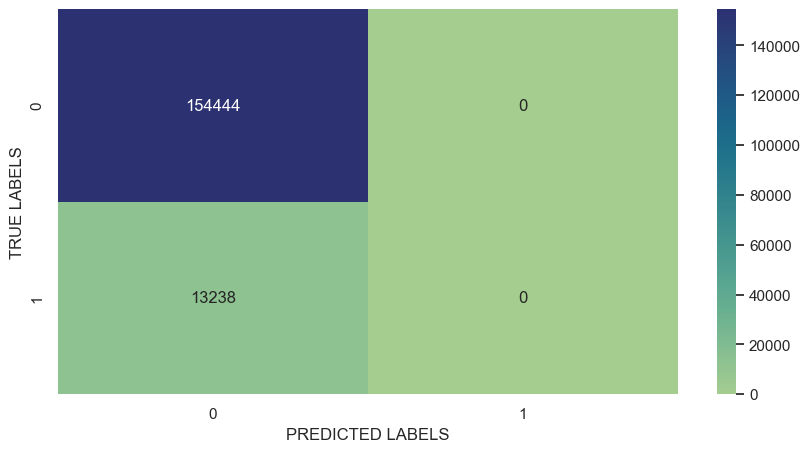

In [131]:
confusion_matrix_DC = create_confusion_matrix_plot(y_train, y_pred_DC)
print(confusion_matrix_DC)

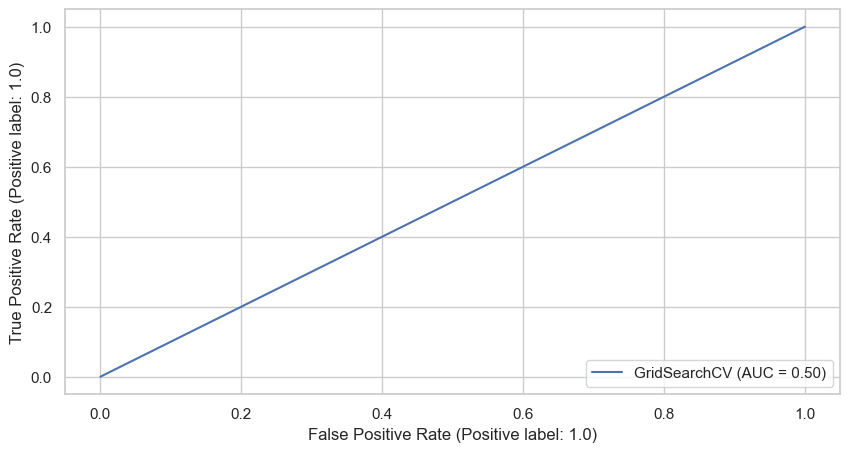

In [132]:
roc_auc_DC = create_roc_auc_plot(grid_search_DC, X_rfecv_train, y_train)

In [133]:
# Save the model DC
log_model(grid_search_DC, name_DC, run_metrics_DC, fit_time_DC, 'confusion_matrix.png', 'roc_auc_curve.png', run_params=None)

Run - DummyClassifier is logged to Experiment - modele_scoring_3


Nous constatons que l'accuracy est très bonne mais cela est due au fait qu'il y a uniquement des true négatifs et faux négatifs qui ont été prédits étant donné que la stratégie du modèle était de prendre le résultat le plus fréquent. Les clients à risque n'ont donc pas été détectés.

Nous allons donc utiliser SMOTE pour mieux rééquilibrer les données.

## Logistic Regression 

In [134]:
name_LR = 'LogisticRegression'

In [135]:
def classifier_pipeline(classifier):
    '''
    Creates a pipeline based on an imputer, smote, scaler and classifier
    Returns the pipeline ready to fit.
    ''' 
    pipe = imbpipeline(steps=[['imputer', imputer],
                               ['smote', smote],
                               ['scaler', scaler],
                               ['classifier', classifier]])
    
    return pipe

imputer = SimpleImputer(strategy = 'median')
smote = SMOTE(random_state=11)
scaler = RobustScaler() #Nous choisissons robust scaler car il n'est pas sensible aux valeurs abbérantes

In [136]:
classifier_LR = LogisticRegression()

LR_pipeline = classifier_pipeline(LogisticRegression())

In [138]:
# nous entrainons le modèle sur 3 jeux de données différents pour s'assurer de sa reproductibilité
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

In [139]:
grid_search_LR = GridSearchCV(estimator=LR_pipeline,
                              param_grid = {},
                           scoring=churn_score,
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search_LR.fit(X_rfecv_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11, shuffle=True),
             estimator=Pipeline(steps=[['imputer',
                                        SimpleImputer(strategy='median')],
                                       ['smote', SMOTE(random_state=11)],
                                       ['scaler', RobustScaler()],
                                       ['classifier', LogisticRegression()]]),
             n_jobs=-1, param_grid={},
             scoring=make_scorer(churnScorer, greater_is_better=False))

In [140]:
y_pred_LR = grid_search_LR.best_estimator_.predict(X_rfecv_train)

In [141]:
fit_time_LR = fit_time(grid_search_LR)

In [142]:
run_metrics_LR = get_metrics_weighted(y_train, y_pred_LR)
print(run_metrics_LR)

{'accuracy': 0.71, 'ROC_AUC': 0.55, 'F1 score weighted': 0.77, 'Fbeta score weighted': 0.73, 'precision weighted': 0.87, 'recall weighted': 0.71, 'score métier': 0.75}


In [146]:
X_rfecv_test = pd.read_csv('X_rfecv_test.csv', index_col=[0])

In [147]:
y_pred_test = grid_search_LR.predict(X_rfecv_test)

In [148]:
# Résultats sur le jeu de test
run_metrics_LGBM_LR_test = get_metrics_weighted(y_test, y_pred_test)
print(run_metrics_LGBM_LR_test)

{'accuracy': 0.71, 'ROC_AUC': 0.55, 'F1 score weighted': 0.77, 'Fbeta score weighted': 0.73, 'precision weighted': 0.87, 'recall weighted': 0.71, 'score métier': 0.74}


None


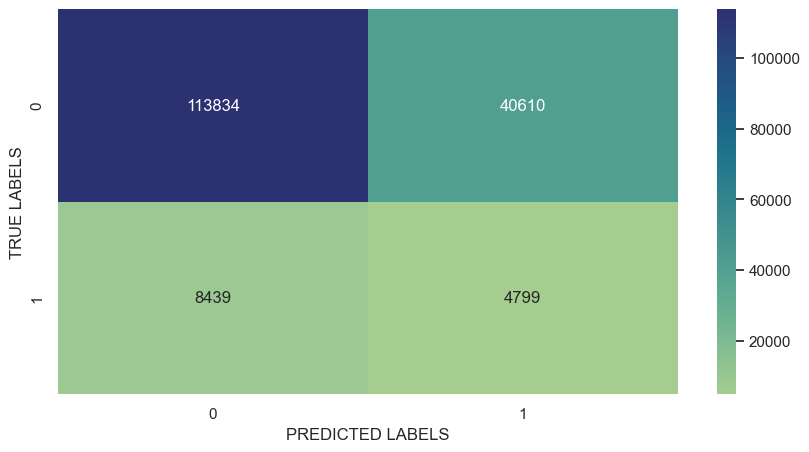

In [143]:
confusion_matrix_LR = create_confusion_matrix_plot(y_train, y_pred_LR)
print(confusion_matrix_LR)

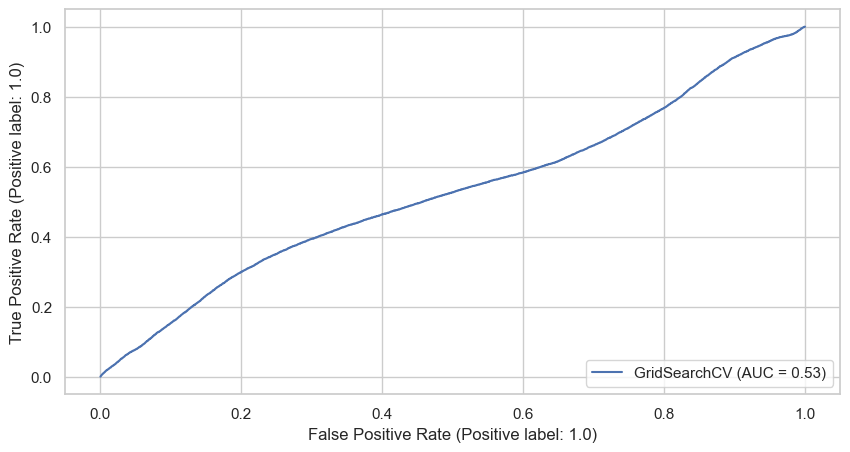

In [144]:
roc_auc_LR = create_roc_auc_plot(grid_search_LR, X_rfecv_train, y_train)

Malgré une accuracy assez élevée, le score métier est trop élevé et le ROC AUC est 0,55 ce qui ne nous permet pas de bien identifier les faux négatifs comme l'illustre la matrice de confusion.

In [246]:
# Save the model LR
log_model(grid_search_LR, name_LR, run_metrics_LR, fit_time_LR, 'confusion_matrix.png', 'roc_auc_curve.png', run_params=None)

Run - LogisticRegression is logged to Experiment - modele_scoring_3


# Random Forest

In [151]:
name_RF = 'RandomForestClassifier'

In [152]:
classifier_RF = RandomForestClassifier()

RF_pipeline = classifier_pipeline(classifier_RF)

In [153]:
grid_search_RF = GridSearchCV(estimator=RF_pipeline,
                              param_grid = {},
                           scoring=churn_score,
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search_RF.fit(X_rfecv_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11, shuffle=True),
             estimator=Pipeline(steps=[['imputer',
                                        SimpleImputer(strategy='median')],
                                       ['smote', SMOTE(random_state=11)],
                                       ['scaler', RobustScaler()],
                                       ['classifier',
                                        RandomForestClassifier()]]),
             n_jobs=-1, param_grid={},
             scoring=make_scorer(churnScorer, greater_is_better=False))

In [156]:
y_pred_RF = grid_search_RF.best_estimator_.predict(X_rfecv_train)

In [157]:
fit_time_RF = fit_time(grid_search_RF)

In [158]:
run_metrics_RF = get_metrics_weighted(y_train, y_pred_RF)
print(run_metrics_RF)

{'accuracy': 1.0, 'ROC_AUC': 1.0, 'F1 score weighted': 1.0, 'Fbeta score weighted': 1.0, 'precision weighted': 1.0, 'recall weighted': 1.0, 'score métier': 0.0}


L'accuracy étant à 1 et le score métier à 0, il y a trop d'overfitting pour ce modèle sur le jeu d'entrainement.

None


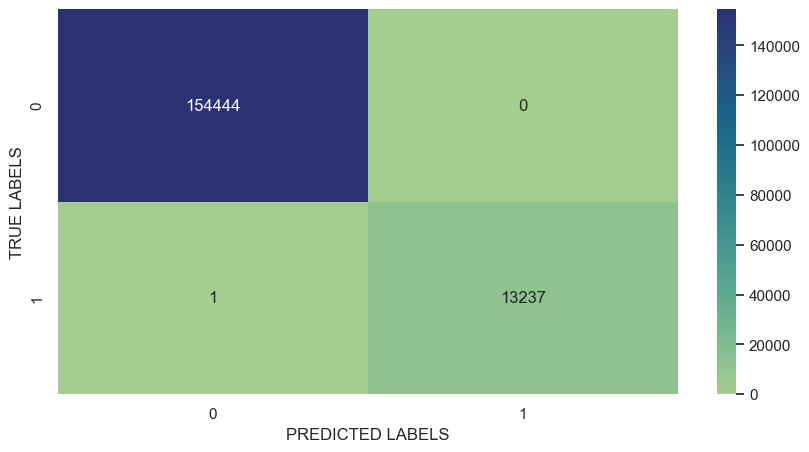

In [159]:
confusion_matrix_RF = create_confusion_matrix_plot(y_train, y_pred_RF)
print(confusion_matrix_RF)

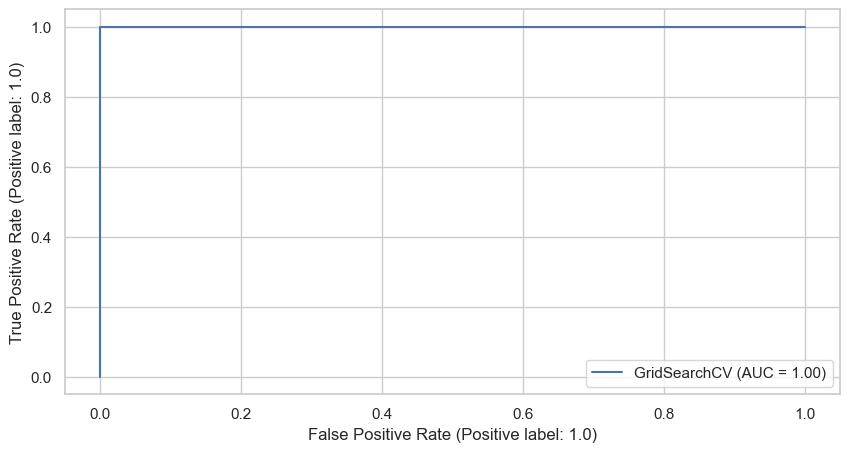

In [160]:
roc_auc_RF = create_roc_auc_plot(grid_search_RF, X_rfecv_train, y_train)

In [161]:
y_pred_test = grid_search_RF.predict(X_rfecv_test)
# Résultats sur le jeu de test
run_metrics_grid_search_RF_test = get_metrics_weighted(y_test, y_pred_test)
print(run_metrics_grid_search_RF_test)

{'accuracy': 0.91, 'ROC_AUC': 0.52, 'F1 score weighted': 0.88, 'Fbeta score weighted': 0.9, 'precision weighted': 0.87, 'recall weighted': 0.91, 'score métier': 0.76}


In [245]:
# Save the model RF
log_model(grid_search_RF, name_RF, run_metrics_RF, fit_time_RF, 'confusion_matrix.png', 'roc_auc_curve.png', run_params=None)

Run - RandomForestClassifier is logged to Experiment - modele_scoring_3


Les résultats sur le jeu de test confirme qu'il y a trop d'overfitting pour ce modèle : score métier très élevé (vs score à 0 pour le jeu d'entrainement) et roc_auc à 0.52 ce qui n'est donc pas un bon score.

## LGBMClassifier 

### LGBMClassifier with smote

In [163]:
name_LGBM_SMOTE = 'LGBMClassifier_SMOTE'

In [164]:
classifier_LGBM = LGBMClassifier(objective='binary')
LGBM_SMOTE_pipeline = classifier_pipeline(classifier_LGBM)

param_grid_LGBM = {}
grid_search_LGBM_SMOTE = GridSearchCV(estimator=LGBM_SMOTE_pipeline,
                           param_grid=param_grid_LGBM,
                           scoring=churn_score,
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search_LGBM_SMOTE.fit(X_rfecv_train, y_train)

[LightGBM] [Info] Number of positive: 154444, number of negative: 154444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33144
[LightGBM] [Info] Number of data points in the train set: 308888, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11, shuffle=True),
             estimator=Pipeline(steps=[['imputer',
                                        SimpleImputer(strategy='median')],
                                       ['smote', SMOTE(random_state=11)],
                                       ['scaler', RobustScaler()],
                                       ['classifier',
                                        LGBMClassifier(objective='binary')]]),
             n_jobs=-1, param_grid={},
             scoring=make_scorer(churnScorer, greater_is_better=False))

In [165]:
y_pred_LGBM_SMOTE = grid_search_LGBM_SMOTE.best_estimator_.predict(X_rfecv_train)

In [166]:
fit_time_LGBM_SMOTE = fit_time(grid_search_LGBM_SMOTE)

In [167]:
run_metrics_LGBM_SMOTE = get_metrics_weighted(y_train, y_pred_LGBM_SMOTE)
print(run_metrics_LGBM_SMOTE)

{'accuracy': 0.92, 'ROC_AUC': 0.52, 'F1 score weighted': 0.89, 'Fbeta score weighted': 0.91, 'precision weighted': 0.89, 'recall weighted': 0.92, 'score métier': 0.76}


None


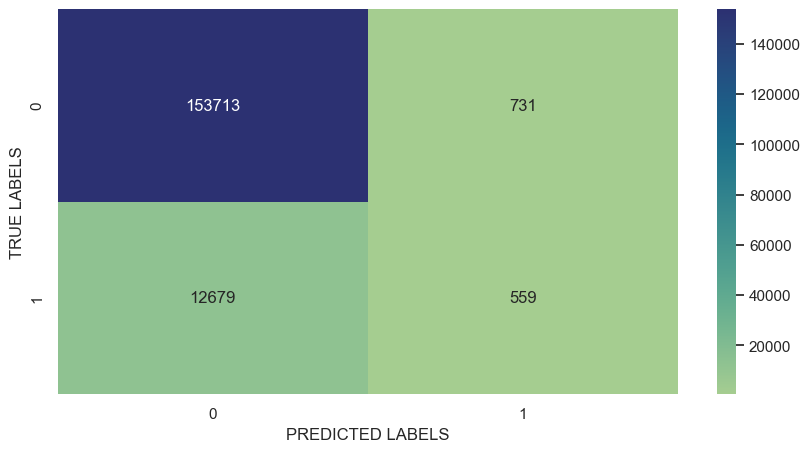

In [168]:
confusion_matrix_LGBM_SMOTE = create_confusion_matrix_plot(y_train, y_pred_LGBM_SMOTE)
print(confusion_matrix_LGBM_SMOTE)

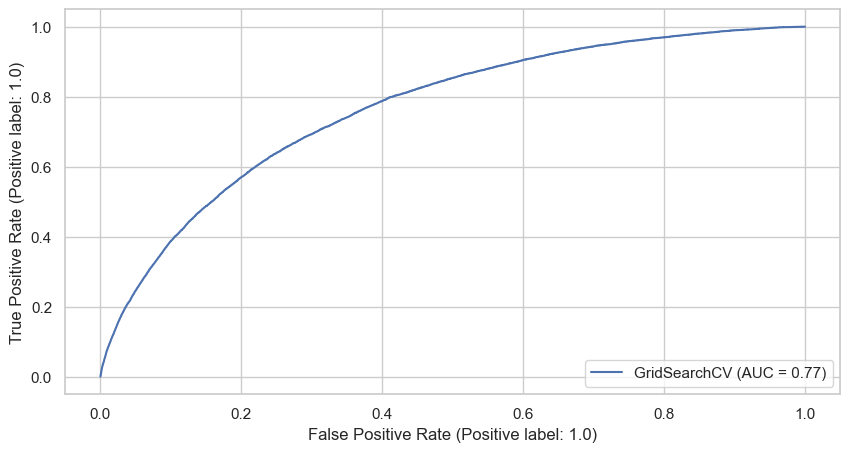

In [169]:
roc_auc_LGBM_SMOTE = create_roc_auc_plot(grid_search_LGBM_SMOTE, X_rfecv_train, y_train)

In [244]:
# Save the model LGBM_SMOTE
log_model(grid_search_LGBM_SMOTE, name_LGBM_SMOTE, run_metrics_LGBM_SMOTE, fit_time_LGBM_SMOTE, 'confusion_matrix.png', 'roc_auc_curve.png', run_params=None)

Run - LGBMClassifier_SMOTE is logged to Experiment - modele_scoring_3


Regardons également les scores sur le jeu de données test :

In [171]:
y_pred_test = grid_search_LGBM_SMOTE.predict(X_rfecv_test)

In [172]:
# Résultats sur le jeu de test
run_metrics_LGBM_SMOTE_test = get_metrics_weighted(y_test, y_pred_test)
print(run_metrics_LGBM_SMOTE_test)

{'accuracy': 0.91, 'ROC_AUC': 0.53, 'F1 score weighted': 0.89, 'Fbeta score weighted': 0.9, 'precision weighted': 0.87, 'recall weighted': 0.91, 'score métier': 0.74}


Nous n'obtenons pas de bons résultats au niveau du ROC AUC et score métier. Nous avons en effet beaucoup de faux négatifs restants avec ce modèle.

# XGBOOST

In [173]:
name_XGB = 'XGBoost'

In [174]:
classifier_XGB = XGBClassifier()
XGB_pipeline = classifier_pipeline(classifier_XGB)

In [175]:
grid_search_XGB = GridSearchCV(estimator=XGB_pipeline,
                              param_grid = {},
                           scoring=churn_score,
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search_XGB.fit(X_rfecv_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11, shuffle=True),
             estimator=Pipeline(steps=[['imputer',
                                        SimpleImputer(strategy='median')],
                                       ['smote', SMOTE(random_state=11)],
                                       ['scaler', RobustScaler()],
                                       ['classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=N...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...)]]),
             n_jobs=-1, param_grid={},
             scoring=make_scorer(churnScorer, greater_is_better=False))

In [176]:
XGB = grid_search_XGB.best_estimator_

In [177]:
y_pred_XGB = XGB.predict(X_rfecv_train)

In [178]:
fit_time_XGB = fit_time(grid_search_XGB)

In [179]:
run_metrics_XGB = get_metrics_weighted(y_train, y_pred_XGB)
print(run_metrics_XGB)

{'accuracy': 0.93, 'ROC_AUC': 0.57, 'F1 score weighted': 0.91, 'Fbeta score weighted': 0.92, 'precision weighted': 0.92, 'recall weighted': 0.93, 'score métier': 0.68}


None


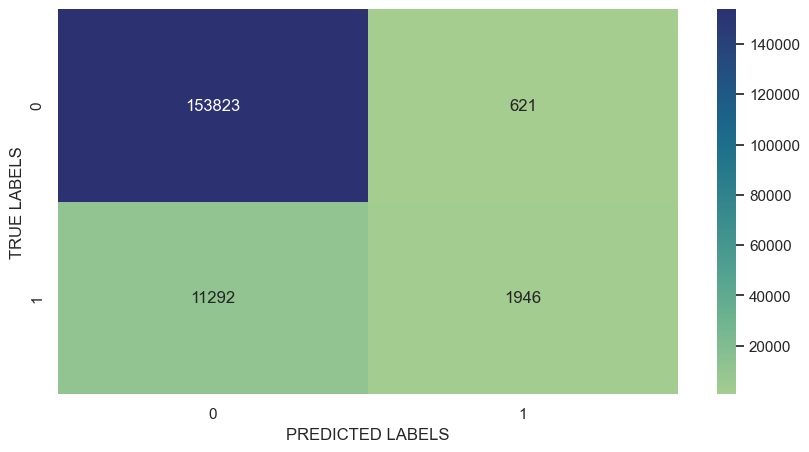

In [180]:
confusion_matrix_XGB = create_confusion_matrix_plot(y_train, y_pred_XGB)
print(confusion_matrix_XGB)

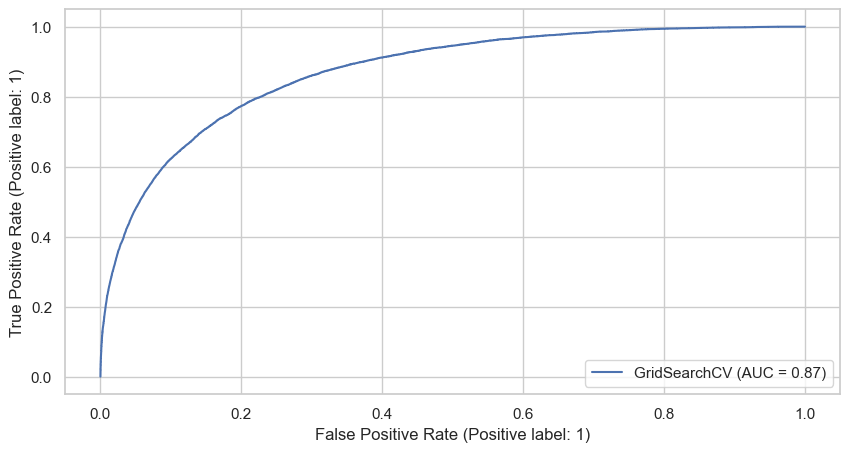

In [181]:
roc_auc_XGB = create_roc_auc_plot(grid_search_XGB, X_rfecv_train, y_train)

In [182]:
# Résultats sur le jeu de test
y_pred = grid_search_XGB.predict(X_rfecv_test)
run_metrics_XGB = get_metrics_weighted(y_test, y_pred)
print(run_metrics_XGB)

{'accuracy': 0.91, 'ROC_AUC': 0.54, 'F1 score weighted': 0.89, 'Fbeta score weighted': 0.9, 'precision weighted': 0.88, 'recall weighted': 0.91, 'score métier': 0.73}


In [242]:
# Save the model LGBM_class_weight
log_model(grid_search_XGB, name_XGB, run_metrics_XGB, fit_time_XGB, 'confusion_matrix.png', 'roc_auc_curve.png', run_params=None)

Run - XGBoost is logged to Experiment - modele_scoring_3


Nous obtenons pour l'instant le score métier le plus faible avec ce modèle mais les clients à risque n'ont toujours pas été bien identifiés (11292 non identifiés/(11292+1946) ce qui est confirmé par un résultat de roc auc assez faible <0.57.

Regardons si les résultats peuvent s'améliorer en optimisant les hyperparamètres :

## Optimisation des hyper paramètres

### XGB_optimized

In [194]:
name_XGB_optimized = 'XGBoost_optimized'

Utilisons hyperopt pour sélectionner les meilleurs hyperparamètres : 

In [58]:
def objective(params):
    score = cross_val_score(XGB_pipeline, X_rfecv_train, y_train, cv=5, scoring=churn_score).mean() 
    return {'loss': -score, 'status': STATUS_OK}

In [59]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 10),  # Integer values from 100 to 1000
    'learning_rate': hp.loguniform('learning_rate', -5, 0),   # Log-uniform distribution
    'max_depth': hp.quniform('max_depth', 1, 10, 1),          # Integer values from 1 to 10
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),           # Continuous values from 0.5 to 1.0
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}

In [60]:
tpe_algo = tpe.suggest

In [67]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe_algo, max_evals=100, trials=trials)

100%|███████████████████████████████████████████| 100/100 [7:07:44<00:00, 256.65s/trial, best loss: 0.7457568624146351]


In [69]:
# Retrieve the Best Hyperparameters
best_n_estimators = int(best['n_estimators'])
best_learning_rate = best['learning_rate']
best_max_depth = int(best['max_depth'])
best_min_child_weight = int(best['min_child_weight'])
best_subsample = best['subsample']
best_colsample_bytree = best['colsample_bytree']

best_params = {
    'n_estimators': best_n_estimators,
    'learning_rate': best_learning_rate,
    'max_depth': best_max_depth,
    'min_child_weight': best_min_child_weight,
    'subsample': best_subsample,
    'colsample_bytree': best_colsample_bytree
}

print("Best hyperparameters:", best_params)

Best hyperparameters: {'n_estimators': 960, 'learning_rate': 0.4288263428518711, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8089281861082454, 'colsample_bytree': 0.5018771685249015}


In [195]:
grid_search_XGB_optimized = GridSearchCV(estimator=XGB_pipeline,
                              param_grid = {
                                            'classifier__n_estimators': [960],
                                            'classifier__learning_rate': [0.4288263428518711],
                                            'classifier__max_depth': [5],
                                            'classifier__subsample': [0.8089281861082454],
                                            'classifier__colsample_bytree': [0.5018771685249015],
                                            'classifier__min_child_weight': [4]
                                         },
                           scoring=churn_score,
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search_XGB_optimized.fit(X_rfecv_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11, shuffle=True),
             estimator=Pipeline(steps=[['imputer',
                                        SimpleImputer(strategy='median')],
                                       ['smote', SMOTE(random_state=11)],
                                       ['scaler', RobustScaler()],
                                       ['classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=N...
                                                      num_parallel_tree=None,
                                                      random_state=None, ...)]]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.5018771685249015],
                         'classifier__learning_rate': [0.4288263428518711],
                         'classifier__max_depth': [5],
                         'classifier__min_child_weight': [4],
                         'classifier__n_estimators': [960],
                         'classifier__subsample': [0.8089281861082454]},
             scoring=make_scorer(churnScorer, greater_is_better=False))

In [196]:
y_pred_XGB_optimized = grid_search_XGB_optimized.best_estimator_.predict(X_rfecv_train)

In [197]:
run_params_XGB_optimized = grid_search_XGB_optimized.best_params_

In [198]:
run_params_XGB_optimized

{'classifier__colsample_bytree': 0.5018771685249015,
 'classifier__learning_rate': 0.4288263428518711,
 'classifier__max_depth': 5,
 'classifier__min_child_weight': 4,
 'classifier__n_estimators': 960,
 'classifier__subsample': 0.8089281861082454}

In [199]:
fit_time_XGB_optimized = fit_time(grid_search_XGB_optimized)

In [200]:
run_metrics_XGB_optimized = get_metrics_weighted(y_train, y_pred_XGB_optimized)
print(run_metrics_XGB_optimized)

{'accuracy': 0.99, 'ROC_AUC': 0.96, 'F1 score weighted': 0.99, 'Fbeta score weighted': 0.99, 'precision weighted': 0.99, 'recall weighted': 0.99, 'score métier': 0.06}


None


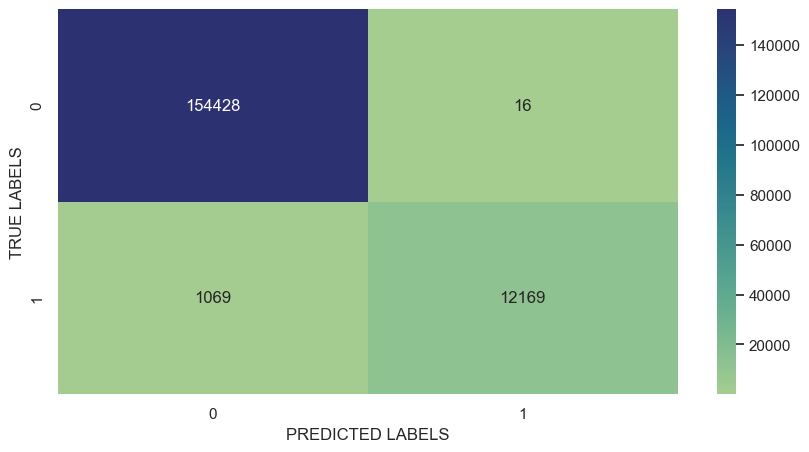

In [201]:
confusion_matrix_XGB_optimized = create_confusion_matrix_plot(y_train, y_pred_XGB_optimized)
print(confusion_matrix_XGB_optimized)

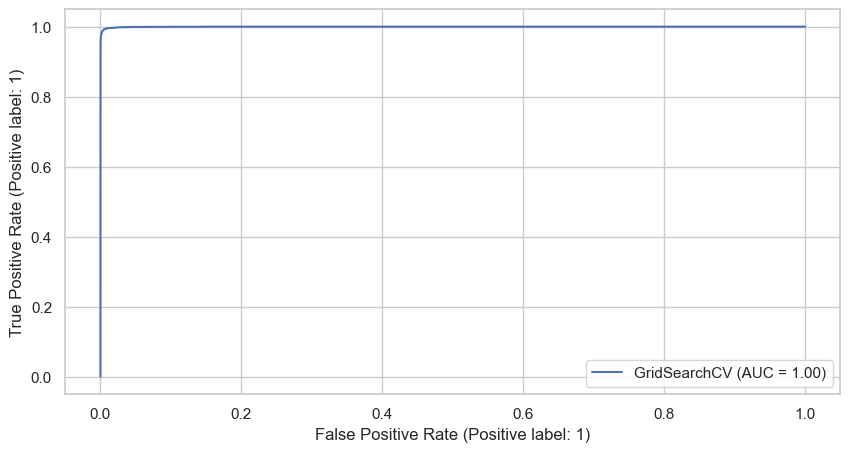

In [202]:
roc_auc_XGB_optimized = create_roc_auc_plot(grid_search_XGB_optimized, X_rfecv_train, y_train)

In [241]:
# Save the model XGB optimized
log_model(grid_search_XGB_optimized, name_XGB_optimized, run_metrics_XGB_optimized, fit_time_XGB_optimized, 'confusion_matrix.png', 'roc_auc_curve.png', run_params=run_params_XGB_optimized)

Run - XGBoost_optimized is logged to Experiment - modele_scoring_3


Les résultats sont très bons (accuracy élevé, score métier faible, ROC_AUC élevé) mais vérifions ces résultats sur le jeu de test :

In [204]:
y_pred_test = grid_search_XGB_optimized.best_estimator_.predict(X_rfecv_test)
# Résultats sur le jeu de test
run_metrics_XGB_optimized_test = get_metrics_weighted(y_test, y_pred_test)
print(run_metrics_XGB_optimized_test)

{'accuracy': 0.9, 'ROC_AUC': 0.56, 'F1 score weighted': 0.89, 'Fbeta score weighted': 0.89, 'precision weighted': 0.88, 'recall weighted': 0.9, 'score métier': 0.71}


Les résultats ne sont pas conservés sur le jeu de test. Nous n'avons pour l'instant pas trouvé de modèle concluant. Retestons le LGBM classifier mais cette fois-ci avec le paramètre class wieght = 'balanced' et non pas SMOTE.

### LGBMClassifier with class_weight = balanced

In [184]:
name_LGBM_class_weight = 'LGBMClassifier_class_weight'

In [185]:
clf = LGBMClassifier(objective='binary', class_weight = 'balanced')
pipeline_LGBM = Pipeline(steps = [['imputer', SimpleImputer(strategy = 'median')],
                                     ['scaler', RobustScaler()], 
                                ['classifier', clf]])
param_grid_LGBM = {}
grid_search_LGBM_class_weight = GridSearchCV(estimator=pipeline_LGBM,
                           param_grid=param_grid_LGBM,
                           scoring=churn_score,
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search_LGBM_class_weight.fit(X_rfecv_train, y_train)

[LightGBM] [Info] Number of positive: 13238, number of negative: 154444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29943
[LightGBM] [Info] Number of data points in the train set: 167682, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11, shuffle=True),
             estimator=Pipeline(steps=[['imputer',
                                        SimpleImputer(strategy='median')],
                                       ['scaler', RobustScaler()],
                                       ['classifier',
                                        LGBMClassifier(class_weight='balanced',
                                                       objective='binary')]]),
             n_jobs=-1, param_grid={},
             scoring=make_scorer(churnScorer, greater_is_better=False))

In [186]:
LGBM_class_weight = grid_search_LGBM_class_weight.best_estimator_

In [189]:
run_metrics_LGBM_class_weight = get_metrics_weighted(y_train, y_pred_LGBM_class_weight)
print(run_metrics_LGBM_class_weight)

{'accuracy': 0.75, 'ROC_AUC': 0.76, 'F1 score weighted': 0.8, 'Fbeta score weighted': 0.76, 'precision weighted': 0.91, 'recall weighted': 0.75, 'score métier': 0.42}


Nous obtenons ainsi des meilleurs scores avec un score métier plus faible et un ROC_AUC plus élevé avec le paramètre class_weight = 'balanced'" qu'avec le SMOTE.

None


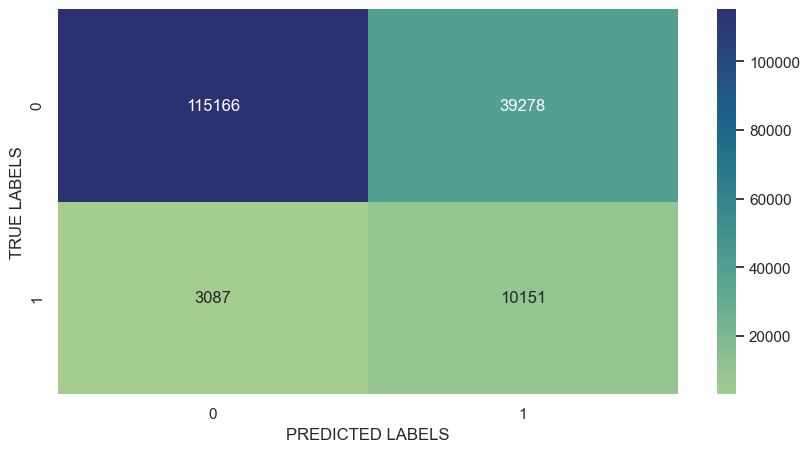

In [190]:
confusion_matrix_LGBM_class_weight = create_confusion_matrix_plot(y_train, y_pred_LGBM_class_weight)
print(confusion_matrix_LGBM_class_weight)

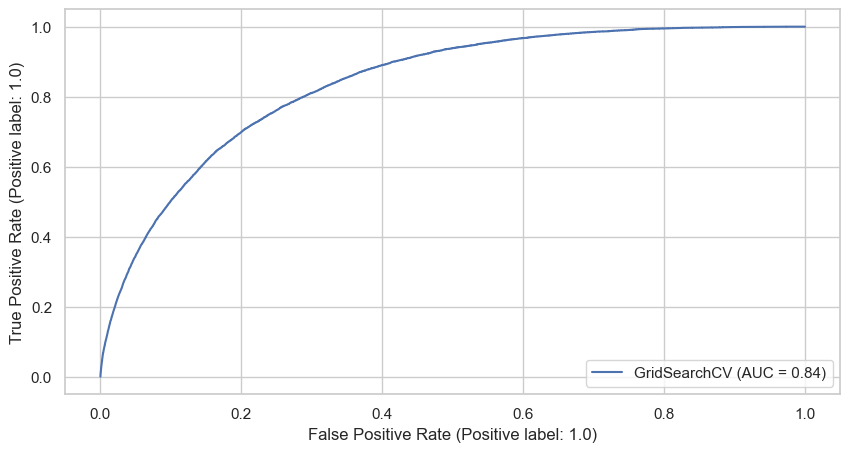

In [191]:
roc_auc_LGBM_class_weight = create_roc_auc_plot(grid_search_LGBM_class_weight, X_rfecv_train, y_train)

In [187]:
y_pred_LGBM_class_weight = LGBM_class_weight.predict(X_rfecv_train)

In [243]:
# Save the model LGBM_class_weight
log_model(grid_search_LGBM_class_weight, name_LGBM_class_weight, run_metrics_LGBM_class_weight, fit_time_LGBM_class_weight, 'confusion_matrix.png', 'roc_auc_curve.png', run_params=None)

Run - LGBMClassifier_class_weight is logged to Experiment - modele_scoring_3


In [193]:
# Résultats sur le jeu de test
y_pred = grid_search_LGBM_class_weight.predict(X_rfecv_test)
run_metrics_LGBM_test = get_metrics_weighted(y_test, y_pred)
print(run_metrics_LGBM_test)

{'accuracy': 0.73, 'ROC_AUC': 0.7, 'F1 score weighted': 0.79, 'Fbeta score weighted': 0.74, 'precision weighted': 0.9, 'recall weighted': 0.73, 'score métier': 0.51}


Les résultats sont également plutôt bons pour le jeu de test.

Nous retenons ce modèle pour lequel nous allons donc optimiser les hyperparamètres.

### LGBMClassifier CW

In [205]:
name_LGBM_CW_optimized = 'LGBMClassifier_CW_optimized'

In [206]:
 # LightGBM parameters found by Bayesian optimization 
#https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm 

clf = LGBMClassifier(objective='binary', class_weight = 'balanced')
pipeline_LGBM_CW_optimized = Pipeline(steps = [['imputer', SimpleImputer(strategy = 'median')],
                                     ['scaler', RobustScaler()], 
                                ['classifier', clf]])

param_grid_LGBM_CW_optimized = {'classifier__num_leaves':[50], #[50, 60, 70],
            'classifier__colsample_bytree': [0.6],#[0.4, 0.6, 0.8],
            'classifier__subsample': [0.3],#[0.3, 0.4, 0.5],
            'classifier__reg_alpha' : [0.2], #[0, 0.1, 0.2],
            'classifier__reg_lambda' : [0] #[0, 0.1, 0.2]
            }
grid_search_LGBM_CW_optimized = GridSearchCV(estimator=pipeline_LGBM_CW_optimized,
                           param_grid=param_grid_LGBM_CW_optimized,
                           scoring=churn_score,
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search_LGBM_CW_optimized.fit(X_rfecv_train, y_train)

[LightGBM] [Info] Number of positive: 13238, number of negative: 154444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29943
[LightGBM] [Info] Number of data points in the train set: 167682, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11, shuffle=True),
             estimator=Pipeline(steps=[['imputer',
                                        SimpleImputer(strategy='median')],
                                       ['scaler', RobustScaler()],
                                       ['classifier',
                                        LGBMClassifier(class_weight='balanced',
                                                       objective='binary')]]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.6],
                         'classifier__num_leaves': [50],
                         'classifier__reg_alpha': [0.2],
                         'classifier__reg_lambda': [0],
                         'classifier__subsample': [0.3]},
             scoring=make_scorer(churnScorer, greater_is_better=False))

In [207]:
LGBM_CW_optimized = grid_search_LGBM_CW_optimized.best_estimator_

In [208]:
run_params_LGBM_CW_optimized = grid_search_LGBM_CW_optimized.best_params_

In [209]:
run_params_LGBM_CW_optimized

{'classifier__colsample_bytree': 0.6,
 'classifier__num_leaves': 50,
 'classifier__reg_alpha': 0.2,
 'classifier__reg_lambda': 0,
 'classifier__subsample': 0.3}

In [210]:
y_pred_LGBM_CW_optimized = grid_search_LGBM_CW_optimized.best_estimator_.predict(X_rfecv_train)

In [211]:
fit_time_LGBM_CW_optimized = fit_time(grid_search_LGBM_CW_optimized).sum()

In [212]:
run_metrics_LGBM_CW_optimized = get_metrics_weighted(y_train, y_pred_LGBM_CW_optimized)
print(run_metrics_LGBM_CW_optimized)

{'accuracy': 0.77, 'ROC_AUC': 0.78, 'F1 score weighted': 0.82, 'Fbeta score weighted': 0.78, 'precision weighted': 0.92, 'recall weighted': 0.77, 'score métier': 0.37}


Nous avons donc réussi à diminuer le score métier de 0.05 points et augmenter l'accuracy et le ROC AUC.

None


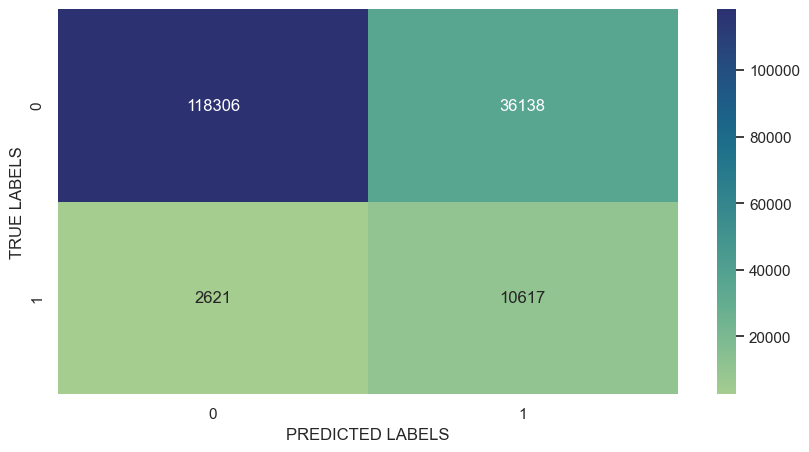

In [213]:
confusion_matrix_LGBM_CW_optimized = create_confusion_matrix_plot(y_train, y_pred_LGBM_CW_optimized)
print(confusion_matrix_LGBM_CW_optimized)

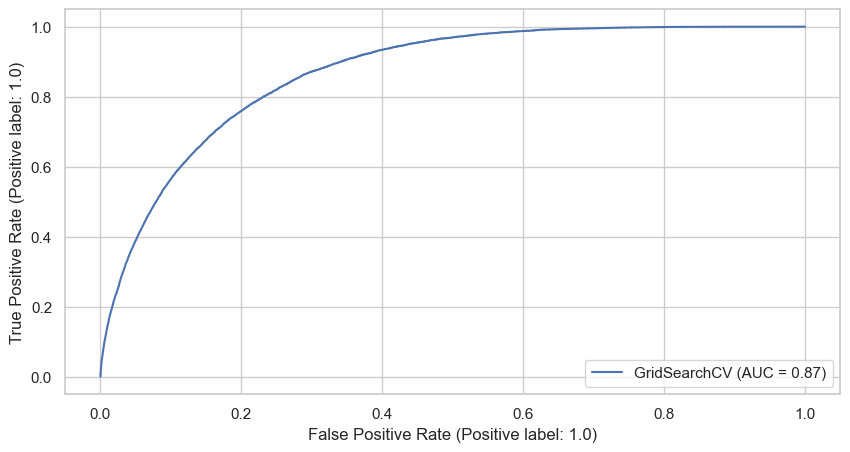

In [214]:
roc_auc_LGBM_CW_optimized = create_roc_auc_plot(grid_search_LGBM_CW_optimized, X_rfecv_train, y_train)

In [240]:
# Save the model LGBM_class_weight
log_model(grid_search_LGBM_CW_optimized, name_LGBM_CW_optimized, run_metrics_LGBM_CW_optimized, fit_time_LGBM_CW_optimized, 'confusion_matrix.png', 'roc_auc_curve.png', run_params=run_params_LGBM_CW_optimized)

Run - LGBMClassifier_CW_optimized is logged to Experiment - modele_scoring_3


In [216]:
y_pred_test = LGBM_CW_optimized.predict(X_rfecv_test)
# Résultats sur le jeu de test
run_metrics_LGBM_CW_optimized_test = get_metrics_weighted(y_test, y_pred_test)
print(run_metrics_LGBM_CW_optimized_test)

{'accuracy': 0.74, 'ROC_AUC': 0.7, 'F1 score weighted': 0.8, 'Fbeta score weighted': 0.76, 'precision weighted': 0.9, 'recall weighted': 0.74, 'score métier': 0.51}


Le score métier augmente légèrement sur le jeu de test mais reste assez faible.

Nous retenons donc le modèle LGBM qui a les meilleurs scores. Sélectionnons maintenant 25 variables qui contribuent le plus au modèle. Il s'agit en effet de pouvoir dire facilement à un client avec quelques variables seulement si un prêt peut lui être accordé.

## Aperçu des 25 features les plus importantes pour construire le modèle

In [217]:
feature_importance = pd.DataFrame()
feature_importance["feature"] = X_rfecv_train.columns

feature_importance["importance"] = LGBM_CW_optimized['classifier'].feature_importances_

feature_importance.sort_values(by=["importance"], ascending=False, inplace=True)

In [218]:
top_25_feature_importance = feature_importance.head(25)
top_25_feature_importance

feature  importance
24                     PAYMENT_RATE         224
52                     EXT_SOURCE_2         155
93                     EXT_SOURCE_3         125
19                       DAYS_BIRTH         112
108                   DAYS_EMPLOYED         103
26                      AMT_ANNUITY          85
25              ANNUITY_INCOME_PERC          70
34                  AMT_GOODS_PRICE          69
45           INSTAL_AMT_PAYMENT_MIN          66
114          ACTIVE_DAYS_CREDIT_MAX          62
30            PREV_CNT_PAYMENT_MEAN          62
57        APPROVED_CNT_PAYMENT_MEAN          61
35           INSTAL_AMT_PAYMENT_SUM          60
21                       AMT_CREDIT          55
50   INSTAL_DAYS_ENTRY_PAYMENT_MEAN          54
69                        POS_COUNT          53
17                  DAYS_ID_PUBLISH          52
48    INSTAL_DAYS_ENTRY_PAYMENT_MAX          51
107              DAYS_EMPLOYED_PERC          49
33            PREV_AMT_ANNUITY_MEAN          49
91    APPROVED_AMT_DOWN_PAYMENT_MAX          47
39                  INSTAL_DBD_MEAN          47
40    INSTAL_DAYS_ENTRY_PAYMENT_SUM          46
28        PREV_APP_CREDIT_PERC_MEAN          46
78             BURO_DAYS_CREDIT_MAX          46

In [219]:
features_selected = feature_importance.head(25)['feature'].to_list()

In [12]:
features_selected = ['PAYMENT_RATE',
                    'EXT_SOURCE_2',
                    'EXT_SOURCE_3',
                    'DAYS_BIRTH',
                    'DAYS_EMPLOYED',
                    'AMT_ANNUITY',
                    'ANNUITY_INCOME_PERC',
                    'AMT_GOODS_PRICE',
                    'INSTAL_AMT_PAYMENT_MIN',
                    'ACTIVE_DAYS_CREDIT_MAX',
                    'PREV_CNT_PAYMENT_MEAN',
                    'APPROVED_CNT_PAYMENT_MEAN',
                    'INSTAL_AMT_PAYMENT_SUM',
                    'AMT_CREDIT',
                    'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
                    'POS_COUNT',
                    'DAYS_ID_PUBLISH',
                    'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
                    'DAYS_EMPLOYED_PERC',
                    'PREV_AMT_ANNUITY_MEAN',
                    'APPROVED_AMT_DOWN_PAYMENT_MAX',
                    'INSTAL_DBD_MEAN',
                    'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
                    'PREV_APP_CREDIT_PERC_MEAN',
                    'BURO_DAYS_CREDIT_MAX']

## test du modèle avec ces 25 features seulement

In [220]:
name_LGBM_CW_features_reduced = 'LGBMClassifier_CW_features_reduced'

In [221]:
LGBM_CW_optimized.fit(X_rfecv_train[features_selected], y_train)

[LightGBM] [Info] Number of positive: 13238, number of negative: 154444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6231
[LightGBM] [Info] Number of data points in the train set: 167682, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ['classifier',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.6,
                                num_leaves=50, objective='binary',
                                reg_alpha=0.2, reg_lambda=0, subsample=0.3)]])

In [222]:
y_pred_LGBM_CW_features_reduced = LGBM_CW_optimized.predict(X_rfecv_train[features_selected])

In [223]:
run_metrics_LGBM_CW_features_reduced = get_metrics_weighted(y_train, y_pred_LGBM_CW_features_reduced)
print(run_metrics_LGBM_CW_features_reduced)

{'accuracy': 0.75, 'ROC_AUC': 0.75, 'F1 score weighted': 0.8, 'Fbeta score weighted': 0.76, 'precision weighted': 0.91, 'recall weighted': 0.75, 'score métier': 0.42}


Nous remarquons donc que nous perdons 0.2 d'accuracy et prenons 0.05 points métier en diminuant le nombre de variables à 25.

None


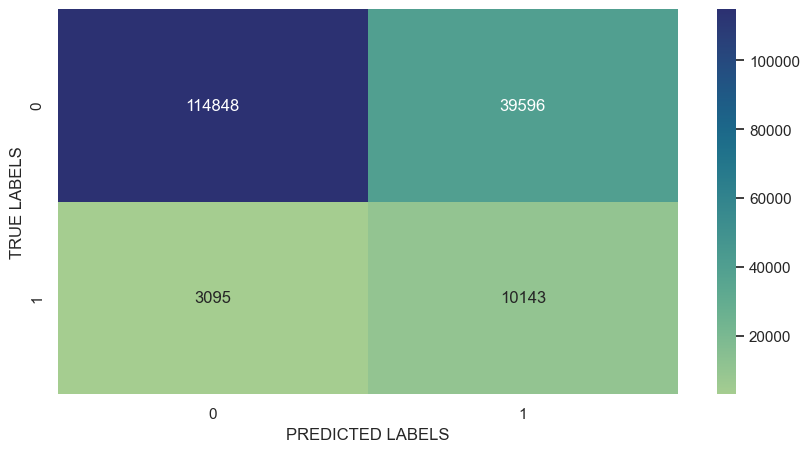

In [224]:
confusion_matrix_LGBM_CW_features_reduced = create_confusion_matrix_plot(y_train, y_pred_LGBM_CW_features_reduced)
print(confusion_matrix_LGBM_CW_features_reduced)

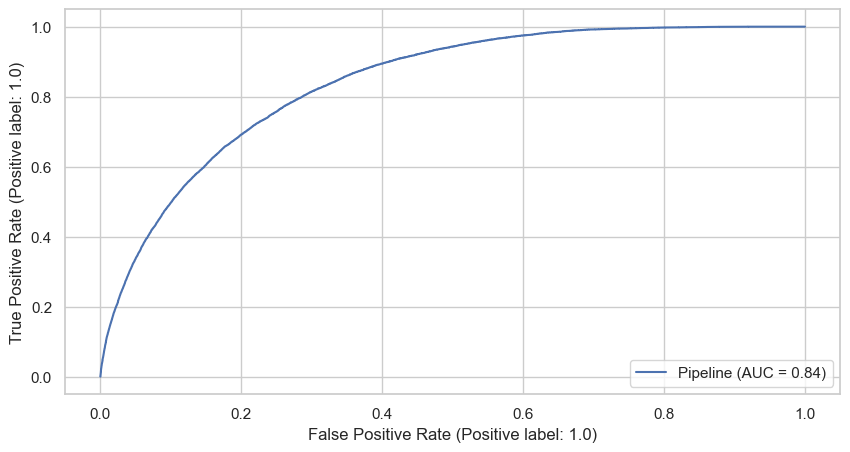

In [225]:
roc_auc_LGBM_CW_features_reduced = create_roc_auc_plot(LGBM_CW_optimized, X_rfecv_train[features_selected], y_train)

In [226]:
y_pred_test = LGBM_CW_optimized.predict(X_rfecv_test[features_selected])
# Résultats sur le jeu de test
run_metrics_LGBM_CW_optimized = get_metrics_weighted(y_test, y_pred_test)
print(run_metrics_LGBM_CW_optimized)

{'accuracy': 0.73, 'ROC_AUC': 0.69, 'F1 score weighted': 0.79, 'Fbeta score weighted': 0.74, 'precision weighted': 0.9, 'recall weighted': 0.73, 'score métier': 0.52}


In [227]:
# création d'une fonction pour enregistrer le modèle dans mlflow (sans le fit_time)
def log_model_v2(model, name, run_metrics, confusion_matrix_path=None, roc_auc_plot_path=None, run_params=None):
    
    # track params and metrics
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag("mlflow.runName", name)
        
        # Set parameters
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
                
        # Set metrics    
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        #mlflow.log_metric("Fit time", fit_time)
            
        # log confusion_matrix
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_matrix')
        
        # log roc_auc_plot    
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        # log model
        mlflow.sklearn.log_model(model, name)
        
    print('Run - %s is logged to Experiment - %s' %(name, experiment_name))
    #mlflow.end_run()

In [239]:
# Save the model LGBM_class_weight_reduced
# fit time pas calculé
log_model_v2(LGBM_CW_optimized, name_LGBM_CW_features_reduced, run_metrics_LGBM_CW_features_reduced, 'confusion_matrix.png', 'roc_auc_curve.png', run_params=run_params_LGBM_CW_optimized)

Run - LGBMClassifier_CW_features_reduced is logged to Experiment - modele_scoring_3


### Enregistrons le meilleur modèle pour le réutiliser sur notre api :

In [43]:
classifier_steps = [step for step in LGBM_CW_optimized.steps if step[0] != 'imputer']
LGBM_CW_optimized_v2 = Pipeline(classifier_steps)

In [44]:
LGBM_CW_optimized_v2

Pipeline(steps=[('scaler', RobustScaler()),
                ['classifier',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.6,
                                num_leaves=50, objective='binary',
                                reg_alpha=0.2, reg_lambda=0, subsample=0.3)]])

In [49]:
# LGBM classifier
lgbm_model = LGBM_CW_optimized_v2

# Serialize model
filename = 'C:/Users/guirletj/Desktop/Test_envir/Projet 7/OC_Credit_Score_Project/api/lgbm_classifier.pkl'
pickle.dump(lgbm_model, open(filename, 'wb'))

In [16]:
# enregistrons le robust scaler entrainé sur notre jeu d'entrainement 
classifier_scaler = LGBM_CW_optimized.steps[1]
# Serialize model
filename = 'C:/Users/guirletj/Desktop/Test_envir/Projet 7/OC_Credit_Score_Project/api/lgbm_robust_scaler.pkl'
pickle.dump(classifier_scaler, open(filename, 'wb'))

## Création d'un seuil métier

In [231]:
faux_neg = []
faux_pos = []
score_metier = []
roc_auc = []
gain = []

thresholds = [x/100 for x in range (30,100,5)]

# optimisation du seuil de décision sur le jeu d'entrainement
for thd in thresholds:
    y_pred = (LGBM_CW_optimized.predict_proba(X_rfecv_train[features_selected])[:,1] >= thd).astype(int)
    vraipos = confusion_matrix(y_train, y_pred)[1][1]
    fauxneg = confusion_matrix(y_train, y_pred)[1][0]
    faux_neg.append(fauxneg)
    fauxpos = confusion_matrix(y_train, y_pred)[0][1]
    vraineg = confusion_matrix(y_train, y_pred)[0][0]
    faux_pos.append(fauxpos)
    #Créons le gain financier qui permet d'estimer ce que l'on gagne réellement en fonction du seuil métier : les vrais négatifs
    # vont payer le taux d'intérêt jusqu'à la fin de leur prêt et les faux négatifs ne vont pas rembourser leur prêt
    gain_financier = (0.025*10000*5)*vraineg-10000*(fauxneg)
    gain.append(gain_financier)
    recall = vraipos/(vraipos+fauxneg)
    f1_score = metrics.f1_score(y_train, y_pred,average='weighted')
    fbeta_score = metrics.fbeta_score(y_train, y_pred,average='weighted', beta=2)
    roc_AUC = metrics.roc_auc_score(y_train, y_pred)
    roc_auc.append(roc_AUC)
    score = churnScorer(y_train, y_pred) #revoir def du score
    score_metier.append(score)
    print("Threshold = ", thd)
    print(f'Vrais Positifs = {vraipos:,}')
    print(f'Vrais Negatifs = {vraineg:,}')
    print(f'Faux Négatifs = {fauxneg:,}')
    print(f'Faux Positifs = {fauxpos:,}')
    print(f"ROC_AUC = {roc_AUC:.2f}")
    print(f'Recall = {recall:.2%}')
    print(f'F1_score = {f1_score:.2%}')
    print(f'Fbeta_score = {fbeta_score:.2%}')
    print(f'Score métier = {score:.2}')
    print(f'Gain financier estimé = {gain_financier:,}')
    print('  ')

Threshold =  0.3
Vrais Positifs = 12,770
Vrais Negatifs = 67,902
Faux Négatifs = 468
Faux Positifs = 86,542
ROC_AUC = 0.70
Recall = 96.46%
F1_score = 57.93%
Fbeta_score = 48.88%
Score métier = 0.54
Gain financier estimé = 80,197,500.0
  
Threshold =  0.35
Vrais Positifs = 12,321
Vrais Negatifs = 81,778
Faux Négatifs = 917
Faux Positifs = 72,666
ROC_AUC = 0.73
Recall = 93.07%
F1_score = 65.51%
Fbeta_score = 57.29%
Score métier = 0.49
Gain financier estimé = 93,052,500.0
  
Threshold =  0.4
Vrais Positifs = 11,774
Vrais Negatifs = 94,092
Faux Négatifs = 1,464
Faux Positifs = 60,352
ROC_AUC = 0.75
Recall = 88.94%
F1_score = 71.51%
Fbeta_score = 64.46%
Score métier = 0.45
Gain financier estimé = 102,975,000.0
  
Threshold =  0.45
Vrais Positifs = 11,013
Vrais Negatifs = 105,002
Faux Négatifs = 2,225
Faux Positifs = 49,442
ROC_AUC = 0.76
Recall = 83.19%
F1_score = 76.28%
Fbeta_score = 70.53%
Score métier = 0.43
Gain financier estimé = 109,002,500.0
  
Threshold =  0.5
Vrais Positifs = 10,14

Nous allons nous baser sur le score métier et le gain financier estimer pour choisir le meilleur seuil de décision.

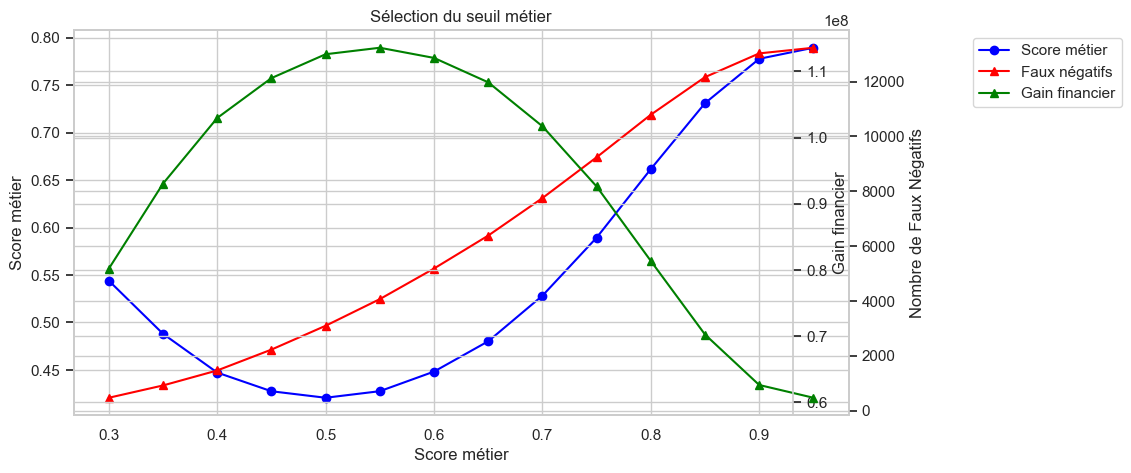

In [232]:
fig, ax = plt.subplots()

# Plotting the first axis
pl = ax.plot(thresholds, score_metier, marker='o', label='Score métier', color='blue')
ax.set_xlabel('Score métier')
ax.set_ylabel('Score métier')
ax.legend(pl, ['Score métier'], bbox_to_anchor=(1.15, 1), loc='lower left')

# Creating the second axis
ax2 = ax.twinx()
pl2 = ax2.plot(thresholds, faux_neg, marker='^', label='Faux négatifs', color='red')
ax2.set_ylabel('Nombre de Faux Négatifs')

# Creating the third axis with an offset
offset = -0.5  # Adjust this value based on your preference
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', offset * 80))
pl3 = ax3.plot(thresholds, gain, marker='^', label='Gain financier', color='green')
ax3.set_ylabel('Gain financier')

# Combining legends
lines = pl + pl2 + pl3
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, bbox_to_anchor=(1.15, 1), loc='upper left')

plt.title('Sélection du seuil métier')
plt.savefig('Selection_seuil_metier.png')
plt.show()

Nous allons retenir le seuil métier à 0.55 car le gain financier est au maximum, l'auc reste élevé (0.75), le nombre de faux négatif (4,067) est assez faible et le score métier est assez bas également (0.43).

## Explication du modèle

Regardons maintenant comment fonctionne le modèle en étudiant l'importance des variables :

### Feature importance globale

In [74]:
LGBM_classifier = LGBM_CW_optimized.named_steps['classifier']
explainer = shap.TreeExplainer(LGBM_classifier)
X_rfecv_train_scaled = RobustScaler().fit_transform(X_rfecv_train[features_selected])
X_rfecv_train_scaled_df = pd.DataFrame(X_rfecv_train_scaled, columns=features_selected)
shap_values = explainer.shap_values(X_rfecv_train_scaled_df)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


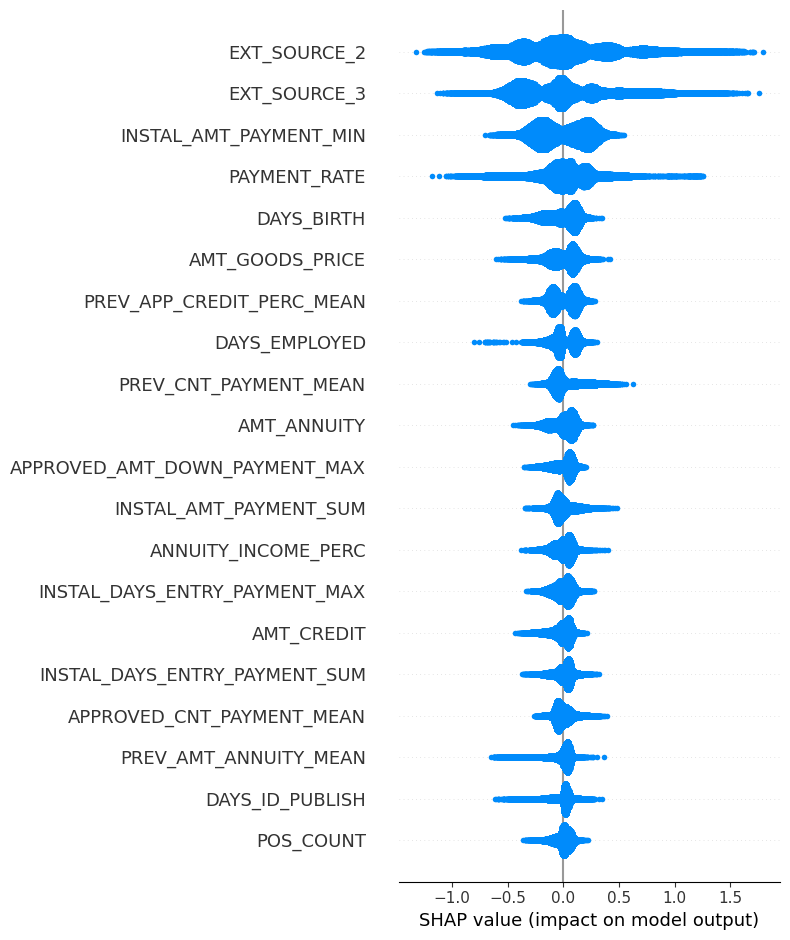

<Figure size 1000x600 with 0 Axes>

In [77]:
shap.summary_plot(shap_values[1], features_selected)
plt.figure(figsize=(10, 6))
plt.savefig('feature_importance_globale.png')

### Feature importance locale

In [78]:
shap_values_customer_to_explain = explainer.shap_values(X_rfecv_train_scaled_df.iloc[[0]])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


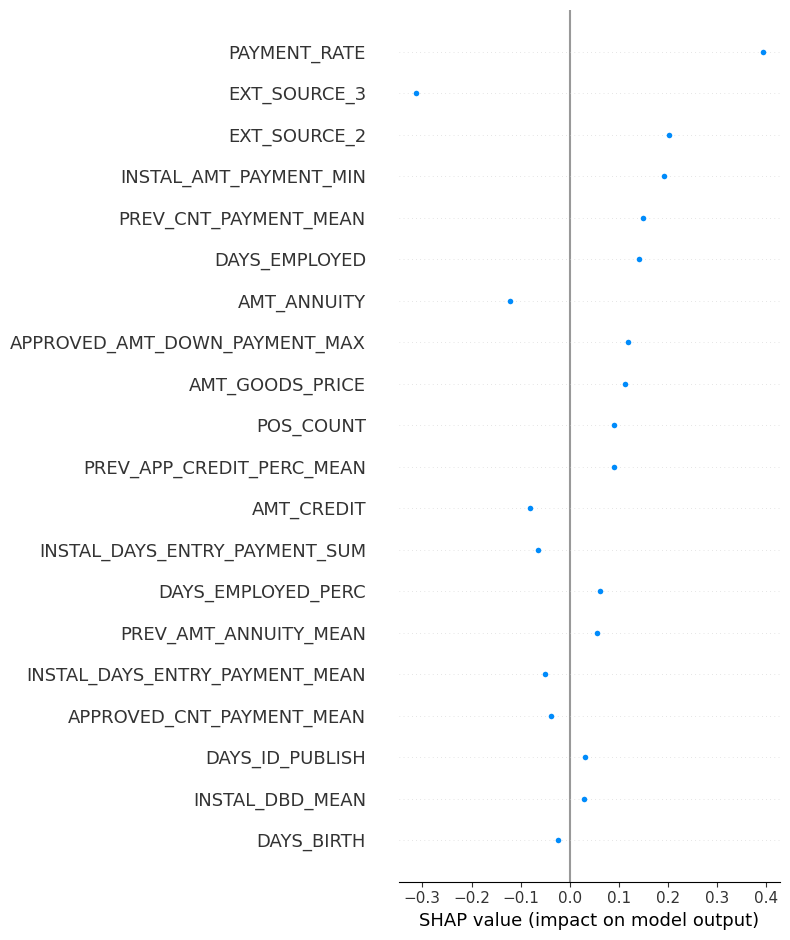

<Figure size 640x480 with 0 Axes>

In [79]:
shap.summary_plot(shap_values_customer_to_explain[1], features_selected)
plt.savefig('feature_importance_locale.png')

### Enregistrons le jeu de données test avec les 25 variables sélectionnées :

In [103]:
features_selected

['PAYMENT_RATE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY',
 'ANNUITY_INCOME_PERC',
 'AMT_GOODS_PRICE',
 'INSTAL_AMT_PAYMENT_MIN',
 'ACTIVE_DAYS_CREDIT_MAX',
 'PREV_CNT_PAYMENT_MEAN',
 'APPROVED_CNT_PAYMENT_MEAN',
 'INSTAL_AMT_PAYMENT_SUM',
 'AMT_CREDIT',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'POS_COUNT',
 'DAYS_ID_PUBLISH',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'DAYS_EMPLOYED_PERC',
 'PREV_AMT_ANNUITY_MEAN',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'INSTAL_DBD_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'PREV_APP_CREDIT_PERC_MEAN',
 'BURO_DAYS_CREDIT_MAX']

In [96]:
predicted_scores = LGBM_CW_optimized.predict_proba(df_merged_test[features_selected])[:,1] 
# predicted score with threshold at 0.55
predicted_class = (predicted_scores>= 0.55).astype(int)
# add predicted class to app_test
df_merged_test['Predicted_Class'] = predicted_class


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [97]:
df_merged_test['Predicted_Class'].value_counts()

0    37107
1    11637
Name: Predicted_Class, dtype: int64

In [98]:
# imputons les valeurs manquantes avec la médiane entrainé sur le jeu d'entrainement pour l'appliquer sur le jeu de test : df_merged_test_reduced
imputer = SimpleImputer(missing_values=np.nan, strategy='median').fit(X_rfecv_train[features_selected])
data_test_imp = pd.DataFrame(imputer.transform(df_merged_test[features_selected]))
data_test_imp.columns = features_selected

In [99]:
data_test_imp.reset_index(drop=True, inplace=True)
df_merged_test.reset_index(drop=True, inplace=True)

In [100]:
data_test_imp['SK_ID_CURR'] = df_merged_test['SK_ID_CURR']

In [101]:
data_test_imp['Predicted_Class'] = df_merged_test['Predicted_Class']

In [102]:
data_test_imp

PAYMENT_RATE  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  DAYS_EMPLOYED  \
0          0.036147      0.789654      0.159520    -19241.0        -2329.0   
1          0.077973      0.291656      0.432962    -18064.0        -4469.0   
2          0.105202      0.699787      0.610991    -20038.0        -4458.0   
3          0.031123      0.509677      0.612704    -13976.0        -1866.0   
4          0.051266      0.425687      0.528300    -13040.0        -2191.0   
...             ...           ...           ...         ...            ...   
48739      0.042354      0.648575      0.643026    -19970.0        -5169.0   
48740      0.051267      0.684596      0.528300    -11186.0        -1149.0   
48741      0.105414      0.632770      0.283712    -15922.0        -3037.0   
48742      0.055840      0.445701      0.595456    -13968.0        -2731.0   
48743      0.079003      0.456541      0.272134    -13962.0         -633.0   

       AMT_ANNUITY  ANNUITY_INCOME_PERC  AMT_GOODS_PRICE  \
0          20560.5             0.152300         450000.0   
1          17370.0             0.175455         180000.0   
2          69777.0             0.344578         630000.0   
3          49018.5             0.155614        1575000.0   
4          32067.0             0.178150         625500.0   
...            ...                  ...              ...   
48739      17473.5             0.143815         270000.0   
48740      31909.5             0.202600         495000.0   
48741      33205.5             0.163978         315000.0   
48742      25128.0             0.111680         450000.0   
48743      24709.5             0.183033         270000.0   

       INSTAL_AMT_PAYMENT_MIN  ACTIVE_DAYS_CREDIT_MAX  ...  \
0                    3951.000                   -49.0  ...   
1                    4813.200                   -62.0  ...   
2                       6.165                  -255.0  ...   
3                       1.170                  -269.0  ...   
4                   11097.450                  -255.0  ...   
...                       ...                     ...  ...   
48739               14222.430                  -303.0  ...   
48740                   2.700                  -255.0  ...   
48741               12640.950                  -229.0  ...   
48742                5519.925                  -890.0  ...   
48743                   1.080                  -760.0  ...   

       INSTAL_DAYS_ENTRY_PAYMENT_MAX  DAYS_EMPLOYED_PERC  \
0                            -1628.0            0.121044   
1                             -470.0            0.247398   
2                              -14.0            0.222477   
3                              -29.0            0.133515   
4                             -466.0            0.168021   
...                              ...                 ...   
48739                         -599.0            0.258838   
48740                          -56.0            0.102718   
48741                          -33.0            0.190742   
48742                          -13.0            0.195518   
48743                          -33.0            0.045337   

       PREV_AMT_ANNUITY_MEAN  APPROVED_AMT_DOWN_PAYMENT_MAX  INSTAL_DBD_MEAN  \
0                 3951.00000                         2520.0         8.857143   
1                 4813.20000                         4464.0        23.666667   
2                11478.19500                         6750.0         5.722581   
3                 8091.58500                        11250.0         3.265487   
4                17782.15500                         8095.5        12.250000   
...                      ...                            ...              ...   
48739            14222.43000                         5827.5         7.333333   
48740             6968.89125                         3600.0         6.000000   
48741            14201.07750                        17086.5        31.625000   
48742            11486.21625                         4500.0         7.275862   
487

In [ ]:
# Exportons le jeu de données test avec classe prédite :

In [103]:
data_test_imp.to_csv('df_merged_test_reduced.csv', index=False)